# Project 02 - Credit Card Classification
by Kevin Spurk

# Table of contents

### 1 Introduction
### 2 Setup
### 3 Data Cleaning
### 4 EDA
### 5 Data Processing
### 6 Baseline Model
### 7 Model Building
### 8 Model Comparison

# 1 Introdution

### Project description

You are working as a risk analyst with a bank. Apart from the other banking and loan services, the bank also provides credit card services which is a very important source of revenue for the bank. The bank wants to understand the demographics and other characteristics of its customers that accept a credit card offer and that do not accept a credit card. Usually the observational data for these kinds of problems is somewhat limited in that often the company sees only those who respond to an offer. To get around this, the bank designs a focused marketing study, with 18,000 current bank customers. This focused approach allows the bank to know who does and does not respond to the offer, and to use existing demographic data that is already available on each customer.

### Objective

The task is to build a model that will provide insight into why some bank customers accept credit card offers. There are also other potential areas of opportunities that the bank wants to understand from the data. Your senior management has also posted these other questions that will help them better understand their customers. These questions get answered in different files, a mySQL file and a Tableau Workbook


# 2 Setup

### 2.1 Library imports

In [1]:
import pymysql
from sqlalchemy import create_engine
import getpass
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import chi2
from scipy.special import inv_boxcox
import pickle
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import os
import math
import random
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.set_option('max_row', None)

In [2]:
password = getpass.getpass()

 ········


### 2.2 mySQL data import

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)

query = '''SELECT *
           FROM credit_card_data;
           '''

data = pd.read_sql_query(query, engine)

# 3 Data cleaning / wrangling

### 3.1 Overview

In [4]:
data.head()

,Customer_Number,Offer_Accepted,Reward,Mailer_Type,Income_Level,Bank_Accounts_Open,Overdraft_Protection,Credit_Rating,Credit_Cards_Held,#_Homes_Owned,Household_Size,Own_Your_Home,Average_Balance,Q1_Balance,Q2_Balance,Q3_Balance,Q4_Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365


In [5]:
data.shape

(17976, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_Number       17976 non-null  int64  
 1   Offer_Accepted        17976 non-null  object 
 2   Reward                17976 non-null  object 
 3   Mailer_Type           17976 non-null  object 
 4   Income_Level          17976 non-null  object 
 5   Bank_Accounts_Open    17976 non-null  int64  
 6   Overdraft_Protection  17976 non-null  object 
 7   Credit_Rating         17976 non-null  object 
 8   Credit_Cards_Held     17976 non-null  int64  
 9   #_Homes_Owned         17976 non-null  int64  
 10  Household_Size        17976 non-null  int64  
 11  Own_Your_Home         17976 non-null  object 
 12  Average_Balance       17976 non-null  float64
 13  Q1_Balance            17976 non-null  int64  
 14  Q2_Balance            17976 non-null  int64  
 15  Q3_Balance         

**Summary**

The dataframe includes **17976 customers**. The csv. file has data for 18000 customers. Due to an error in the data import of the csv. file into a mySQL database, there was a negligible loss of data. The customer data is stored in a total of **17 columns - 10 numerical and 7 categorical**. There are **no null values** present, but in a following step I'm checking im the data contains zeros that have to be dealt with. The column `Customer_Number` is going to be used as an index.

### 3.2 Indexing

In [7]:
data.rename(columns={'Customer_Number':'id'}, inplace=True)
data = data.set_index('id')

### 3.3 Cleaning headers

In [8]:
columns_list = []
pattern = '#_'

for column in data.columns:
    column = re.sub(pattern, '', column)
    columns_list.append(column)

data.columns = columns_list

In [9]:
def clean_headers(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    return df

In [10]:
clean_headers(data)
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
id,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365


### 3.4 Data cleaning

**Checking for negative values and unwanted zeros**

In [11]:
for column in data.select_dtypes(np.number):
    print(column, 'Negative values:', len(data[data[column] < 0]), 'Zeros:', len(data[data[column] == 0]), '\n')

bank_accounts_open Negative values: 0 Zeros: 0 

credit_cards_held Negative values: 0 Zeros: 0 

homes_owned Negative values: 0 Zeros: 0 

household_size Negative values: 0 Zeros: 0 

average_balance Negative values: 0 Zeros: 0 

q1_balance Negative values: 0 Zeros: 5 

q2_balance Negative values: 0 Zeros: 1 

q3_balance Negative values: 0 Zeros: 1 

q4_balance Negative values: 0 Zeros: 5 



**Conclusion**

Zeros in the balance columns are to be expected and don't have to be dealt with. There's no further data cleaing to do.

# 4 EDA

### 4.1 Exploration of numerical features

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
bank_accounts_open,17976.0,1.255730,0.472405,1.00,1.00,1.0,1.00,3.00
credit_cards_held,17976.0,1.903427,0.797086,1.00,1.00,2.0,2.00,4.00
homes_owned,17976.0,1.203549,0.427446,1.00,1.00,1.0,1.00,3.00
household_size,17976.0,3.499110,1.114476,1.00,3.00,3.0,4.00,9.00
average_balance,17976.0,940.515562,350.297837,48.25,787.50,1007.0,1153.25,3366.25
q1_balance,17976.0,910.450656,620.077060,0.00,392.75,772.0,1521.00,3450.00
q2_balance,17976.0,999.392190,457.402268,0.00,663.00,1032.0,1342.00,3421.00
q3_balance,17976.0,1042.033600,553.452599,0.00,633.00,945.5,1463.00,3823.00
q4_balance,17976.0,810.185803,559.001365,0.00,363.00,703.0,1212.00,4215.00


**Conclusion**

The mean and the median reveal that the average customer has **one bank account**, holds **2 credit cards** and owns **one house** living in a **household of 3 people**. The balance columns for the different quarters show little fluctuation, only the **average balance in Q4 being noticeably lower** compared to the others and Q1 and Q4 having lower median and 25 percentile values.

The balance columns contain continuous values. The other numerical columns contain discrete values. Too allow for further exploration of the numerical features, I’m separating the data (including categorical features) into  them into three categories:

| feature type        | value count      |
| ------------------- | ---------------- |
| continous variables | > 10             |
| discrete variable   | between 3 and 10 |
| boolean variables   | 2                |




In [13]:
# categorise columns into continous, discrete and boolean variables based on a selected threshold for their value counts

def var_classification(df, bln, disc, columns=[] ,skip=[]):
    df_bln = df.copy()
    df_discrect = df.copy()
    df_cont = df.copy()
    
    if columns == []:
        columns = df.columns
    
    for column in columns:
        if column not in skip:
            if df[column].nunique() <= bln:
                df_bln[column] =  df_bln[column].astype('category')
                df_discrect = df_discrect.drop(column, axis=1)
                df_cont = df_cont.drop(column, axis=1)
            elif (df[column].nunique() > bln) & (df[column].nunique() < disc):
                df_bln = df_bln.drop(column, axis=1)
                df_cont = df_cont.drop(column, axis=1)
            else:
                df_bln = df_bln.drop(column, axis=1)
                df_discrect = df_discrect.drop(column, axis=1)
    return df_bln, df_discrect, df_cont

In [14]:
data_bln, data_discrete, data_cont = var_classification(data, bln=2, disc=10)


**Correlations**

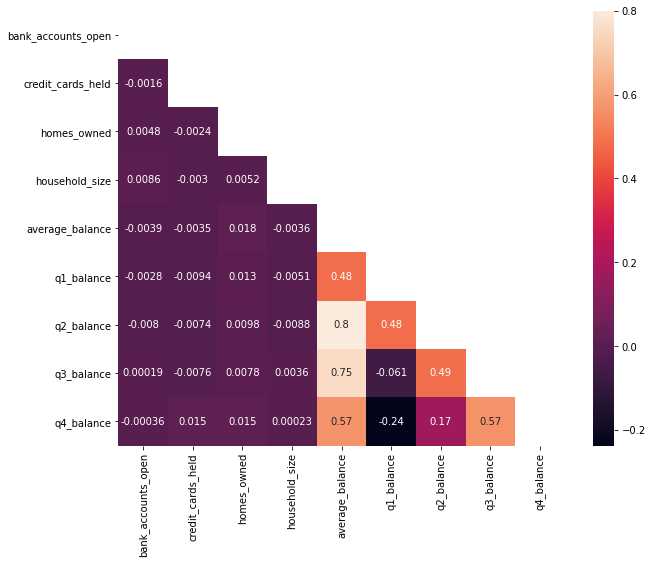

In [15]:
# Heatmap
corr_matrix=data.corr(method='pearson')

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

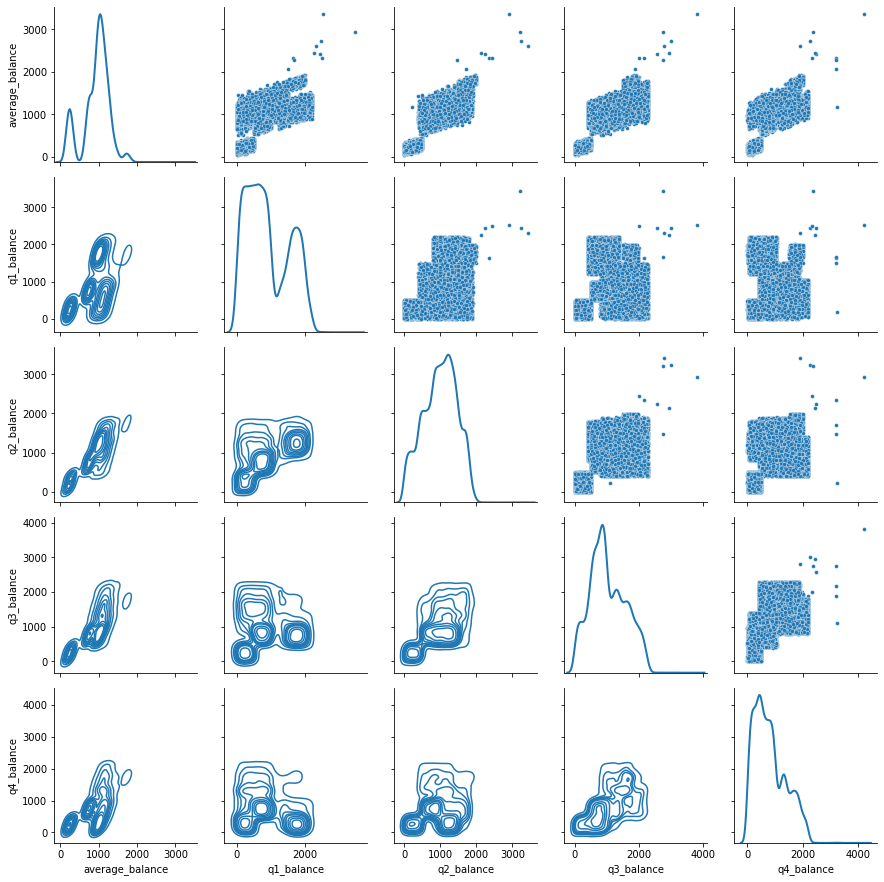

In [16]:
# Paired density and scatterplot matrix

pgrid_1 = sns.PairGrid(data_cont, diag_sharey=False)
pgrid_1.map_upper(sns.scatterplot, s=15)
pgrid_1.map_lower(sns.kdeplot)
pgrid_1.map_diag(sns.kdeplot, lw=2)

**Conclusions**

Many of the balance columns show significant correlation with each other, most notably `average_balance`  is highly correlated with `q1_balance` (0.8) and `q2_balance` (0.75). The other columns show no significant correlations. A plot overview confirms the results of the correlation heatmap. 

**Value distributions**

In [17]:
# function to display distribution plots and boxplots of columns in a df. 

def plots_continuous_var(df, columns=[], skip=[]):
    if columns == []:
        columns = df.columns
    for column in columns:
        if column not in skip:
            print('\n')
            custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
            sns.set_theme(style="whitegrid", rc=custom_params)
            fig, axes = plt.subplots(1, 2, figsize=(18, 5))
            sns.distplot(df[column], ax=axes[0])
            sns.boxplot(df[column], ax=axes[1])
            plt.show()

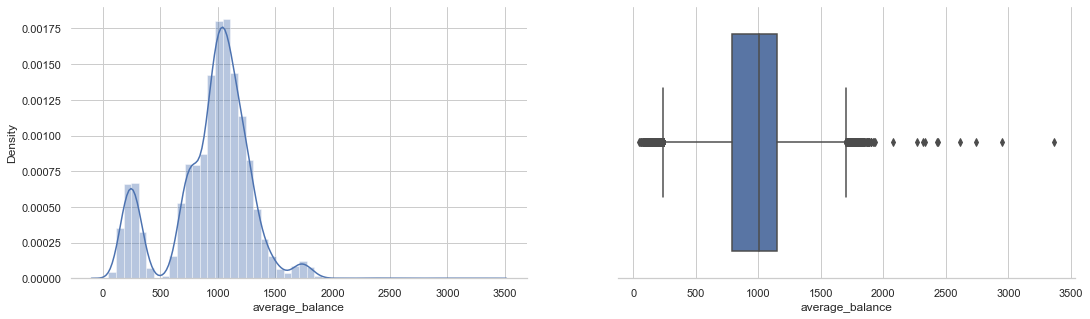

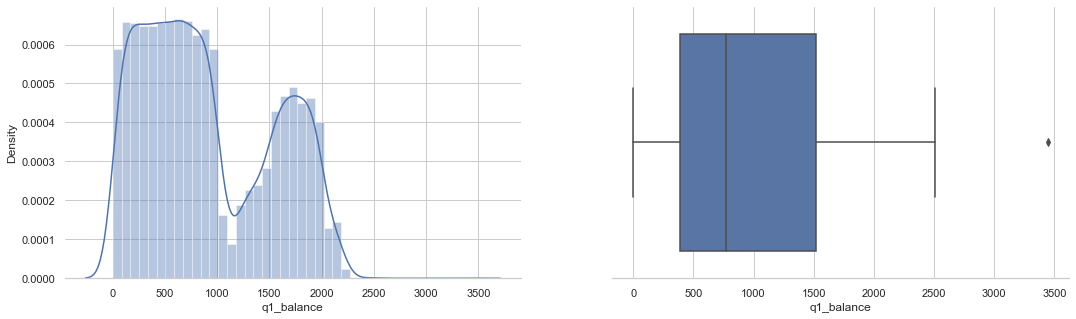

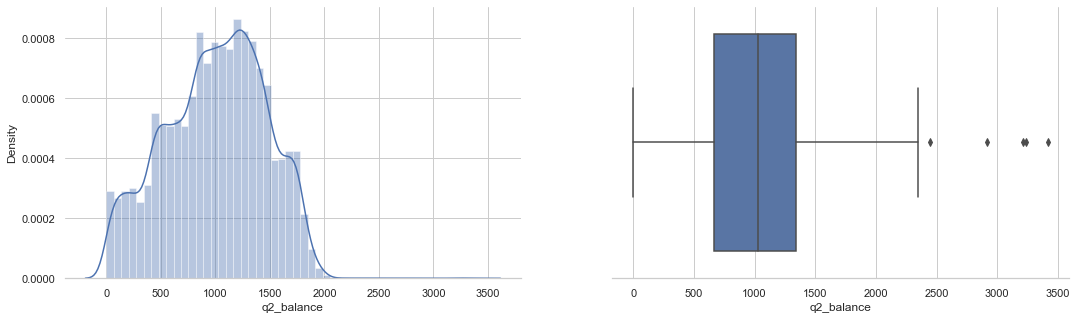

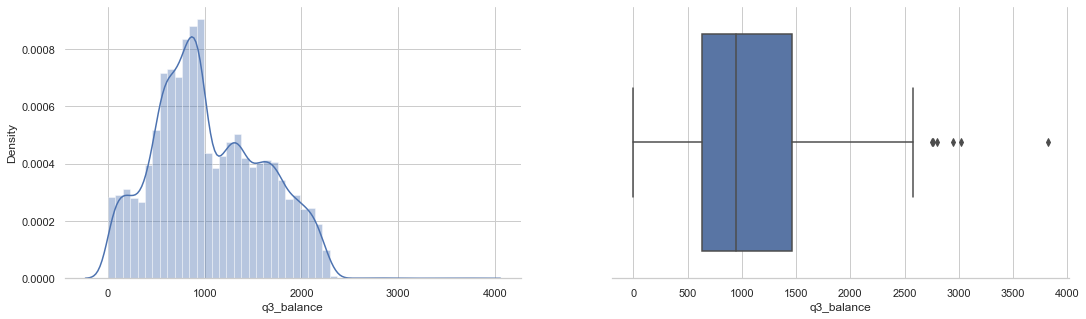

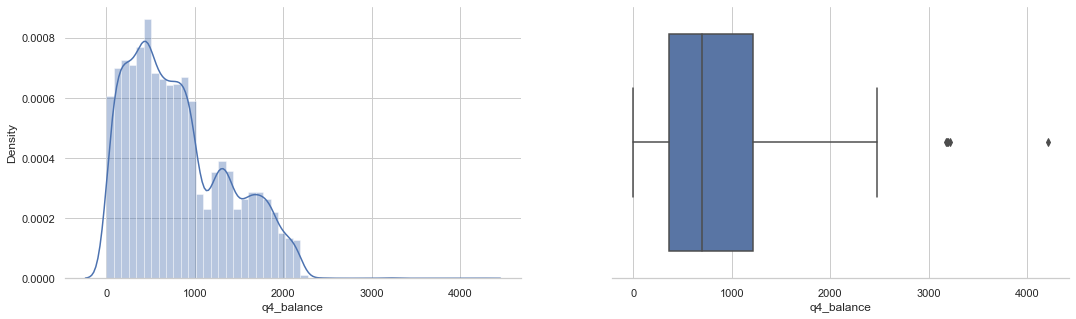

In [18]:
plots_continuous_var(data_cont)

**Conclusions**

`q2_balance`, `q3_balance` and `q4_balance` are resemble a normal distribution, but with median shifted to the left in case of q3 and q4 and to the right in case of q2. The could be good candidates for boxcox transformation to improve model performance. `q1_balance` and `average_balance` resemble a normal distribution less, because of their two peaks. With the exception of `average_balance` the balance variables have relatively few outliers, which is why `average_balance` could benefit the most from removing outliers with respect to improving its performance in a model.

### 4.2 Exploration of categorical features

**Value occurances**

In [19]:
for column in data.select_dtypes(np.object):
    print(column, data[column].value_counts(), '\n')

offer_accepted No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

reward Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

mailer_type Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

income_level Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

overdraft_protection No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

credit_rating High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

own_your_home Yes    11636
No      6340
Name: own_your_home, dtype: int64 



**Conclusion**

The value count for `offer_accepted` reveals a **large class imbalane in the target variable** that I'm balancing later in 6. A summary about the caracteristics of the other variables is given with the following visual explorations.

### 4.3 Visual exploration of features with descrete values

In [20]:
# function to display count plots and boxplots of columns in a df. 

def plots_discrete_var(df, columns=[], skip=[]):
    if columns == []:
        columns = df.columns
    for column in columns:
        if column not in skip:
            print('\n')
            custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
            sns.set_theme(style="whitegrid", rc=custom_params)
            fig, axes = plt.subplots(1, 2, figsize=(16, 5))
            sns.countplot(df[column], ax=axes[0], palette="dark", alpha=.7)
            sns.boxplot(df[column], ax=axes[1])
            plt.show()


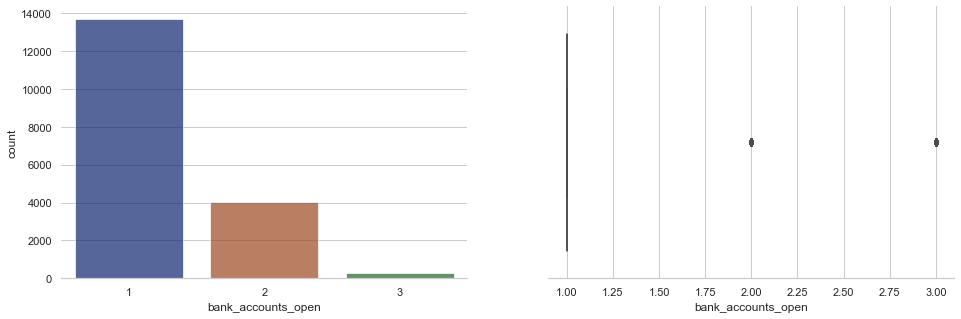

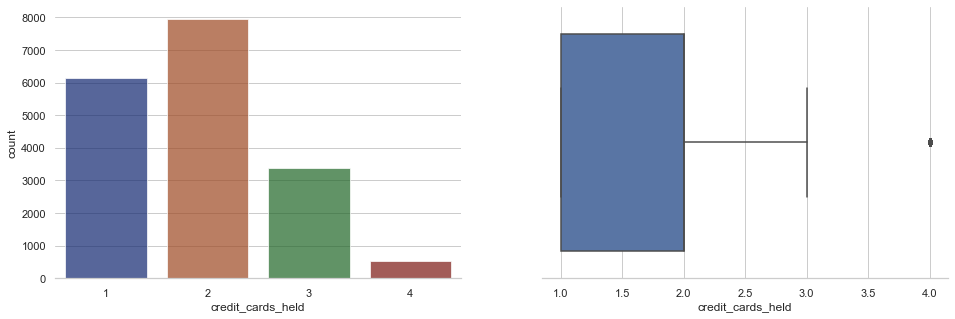

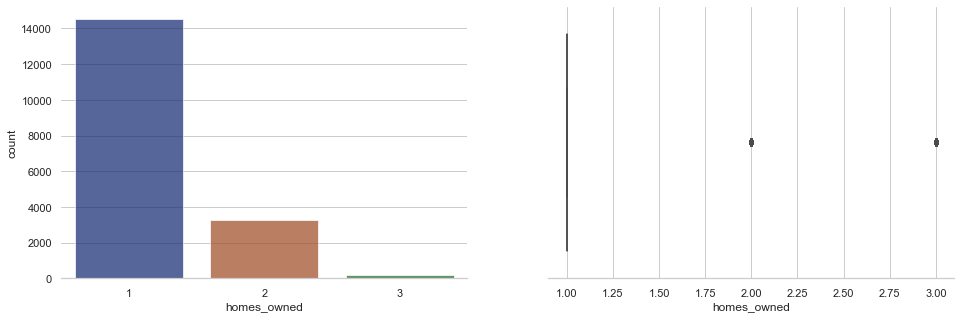

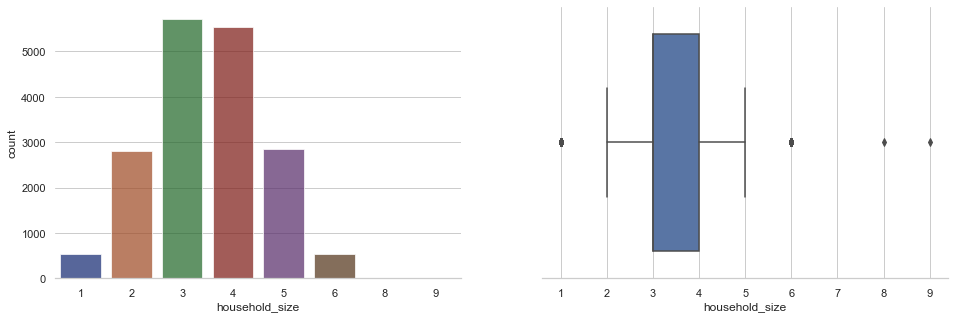

In [21]:
plots_discrete_var(data_discrete, skip=['reward', 'income_level', 'credit_rating'])

**Summary**

A large majority of customers has one bank account and own one house. `credit_cards_held` and `household_size` resemble a normal distribution with most customers having 1 or 2 credit cards and living in households of 3 or 4 people. Generally there are not many outliers in those columns.

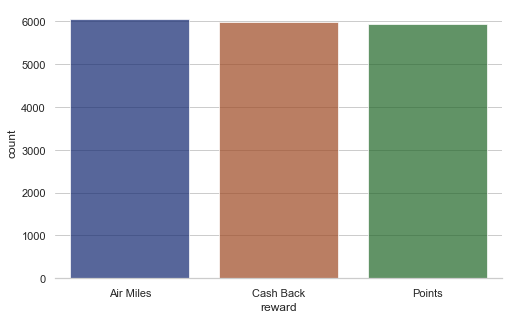

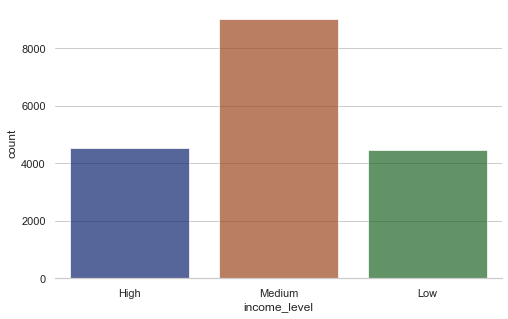

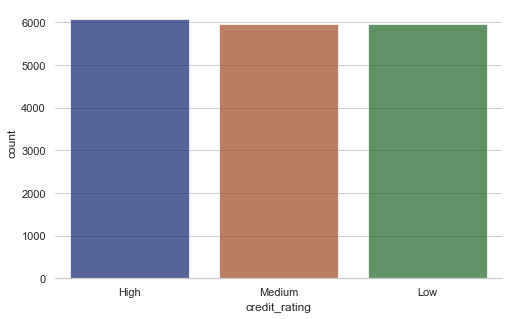

In [22]:
data_discrete_cat = data_discrete.drop(['household_size', 'homes_owned', 'credit_cards_held', 'bank_accounts_open'], axis=1)

for column in data_discrete_cat:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.countplot(x=data_discrete_cat[column], palette="dark", alpha=.7)
    sns.despine(left=True)
    plt.show()
    

**Summary**

While `reward` and `credit_rating` are evenly distributed, around 50% of customer have a medium income, ca 25% high or low income respectively.

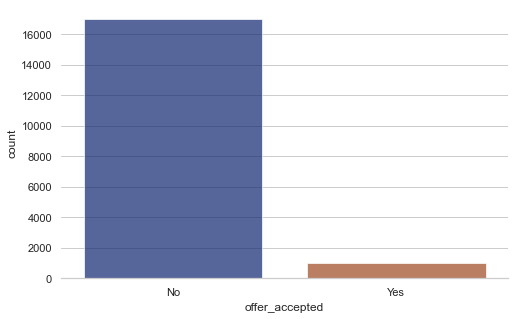

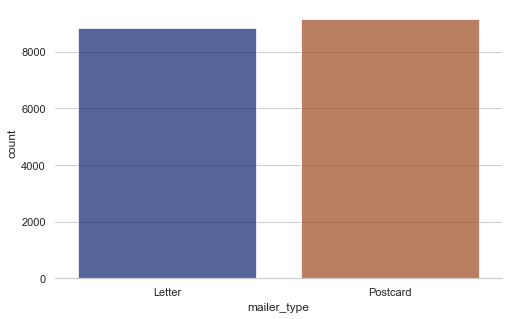

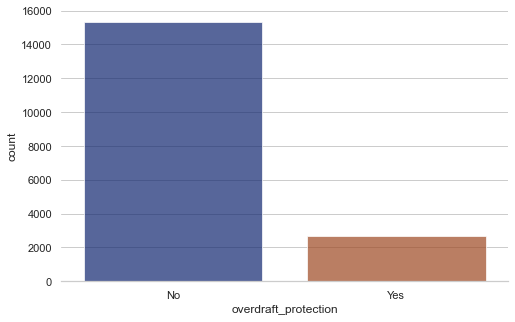

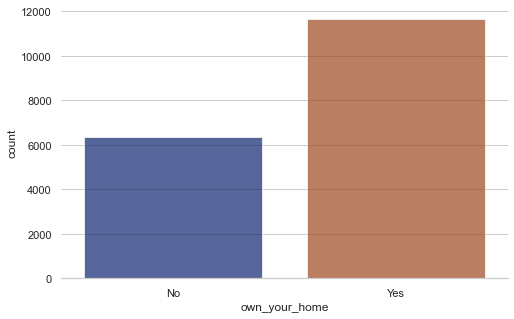

In [23]:
for column in data_bln:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.countplot(x=data_bln[column], palette="dark", alpha=.7)
    sns.despine(left=True)
    plt.show()

**Summary**

The plots show that in addition to the highly imbalanced target variable, the variables `overdraft_protection` and `own_your_home` also have a large difference between majority and minority class, whereas `mailer_type` is evenly distributed for the values ‘Letter’ and ‘Postcard’.

# 5 Data processing

### 5.1 Feature selection

**Selection based on correlations**

The correlation matrix in step 4.1 didn't reveal any features that should neccessarily be dropped. The correlation of 'average_balance' with 'q2_balance' and 'q3_balance' is high (0.75 and 0.8) but I would only consider it a save drop with a value above 0.8. 

**Selection based on multicolinearity / Variance Inflation Factor (VIF)**

Through multivariate linear regression, I'm trying to assess the influence of each of the predictor variables on the target variable. Multicollinearity is a potential issue for the model performance. To identify problematic variables I'm calculating the Variance Inflation Factors (VIFs) and  try to mitigate the problem later by transforming those variables (centering, standardizing, normalizing) or remove them from the model completely.

In [24]:
data_num = data.select_dtypes(np.number)

list(data_num.columns.values)

['bank_accounts_open',
 'credit_cards_held',
 'homes_owned',
 'household_size',
 'average_balance',
 'q1_balance',
 'q2_balance',
 'q3_balance',
 'q4_balance']

In [116]:
features = "+".join(['bank_accounts_open', 'credit_cards_held', 'homes_owned', 'household_size', 'average_balance',
                     'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])

VIF_y, VIF_X = dmatrices('offer_accepted ~' + features, data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(VIF_X.values, i) for i in range(VIF_X.shape[1])]
vif["features"] = VIF_X.columns

vif.round(2).style.hide_index()

VIF Factor,features
38.270000,Intercept
1.000000,bank_accounts_open
1.000000,credit_cards_held
1.000000,homes_owned
1.000000,household_size
inf,average_balance
inf,q1_balance
inf,q2_balance
inf,q3_balance
inf,q4_balance


**Conclusions**

A VIF of 1 shows that the variable is not correlated with any other independent variable. Multicollinearity is a potential problem when the VIF is greater than 4 and, a serious problem when it is greater than 10. The quaterly balances and the average balance are not independent. It can still make sense to keep them. They represent a chronological order. Therfore in this case there are no features to remove.

**Selection of categorical features / Chi2 Test**

Chi-square test to determine if there is a significant relationship between two categorical varables. 

**H0 (Null Hypothesis)** - there is no association between the two variables.

The following function calculates the **p value** and the **chi2 test statistic** for each combination of 2 variables based on the contingency table. The chi2 test statistic is calculated to helps decide whether the variables are independent or not, i.e. those values help to determine if the null hypothesis can be accepted or has to be rejected.

Some numerical variables with only few descrete values could be treated as categorical (ordinal) variables in order to compare more variables. It doesn't make much sense to include them in a chi2-Test though, because the test doesn't work well with ordinal variables. The order in which value frequencies are put in the contingency table to calculate the chi2 test statistics doesn't matter - a fact that has to be taken into account when later reviewing the test results.

In [26]:
# function with inputs: df of categorical values, confidence probability 
# neccessary import: 'from scipy.stats import chi2'

def chi2_check(df, conf=95):
    # create dfs for chi2 calculated, diffrence between chi2 calculated and critical value, p-value
    df_chi2calc = pd.DataFrame(index=df.columns, columns=df.columns)
    df_chi2diff = pd.DataFrame(index=df.columns, columns=df.columns)
    df_p = pd.DataFrame(index=df.columns, columns=df.columns)
    
    # creste array with critical values of chi2 distribution
    p = np.array([0.05, 0.01, 0.001])
    deg_f = np.array(range(1, 31)).reshape(-1, 1)
    chi2_table = pd.DataFrame(chi2.isf(p, deg_f), columns=['95', '99', '99.9'])
    
    # fill dfs with values from chi2 tests
    for i in df.columns:
        for j in df.columns:
            if i != j:
                # chi2 calculated and p-value
                data_crosstab = pd.crosstab(data[i], data[j], margins = False)
                chi2_results = chi2_contingency(data_crosstab, correction=False)
                df_chi2calc[i].loc[j] = round(chi2_results[0],2)
                df_p[i].loc[j] = round(chi2_results[1],2)
                
                # diffrence between chi2 calculated and critical value
                table_dof = chi2_results[2] - 1
                for c in chi2_table.columns:
                    if float(c) == conf:
                        if chi2_results[2] < 30:
                            df_chi2diff[i].loc[j] = round((chi2_results[0] - chi2_table[c].loc[table_dof]), 2)
                        else:
                            df_chi2diff[i].loc[j] = round((chi2_results[0] - chi2_table[c].loc[29]), 2)
    
    # filling values along the df diagonals with '-'
    df_chi2calc = df_chi2calc.fillna('-')
    df_chi2diff = df_chi2diff.fillna('-')
    df_p = df_p.fillna('-')
    
    return df_chi2calc, df_chi2diff, df_p
                                 

In [27]:
data_cat = data.select_dtypes(np.object)

data_chi2calculated, data_chi2difference, data_chi2p = chi2_check(data_cat)


**Overview of calculated chi2 values**

In [28]:
data_chi2calculated

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
offer_accepted,-,101.15,169.88,113.62,0.13,445.06,0.0
reward,101.15,-,0.81,2.42,1.66,2.4,1.87
mailer_type,169.88,0.81,-,1.07,0.15,0.66,0.33
income_level,113.62,2.42,1.07,-,1.22,2.98,2.16
overdraft_protection,0.13,1.66,0.15,1.22,-,1.35,1.28
credit_rating,445.06,2.4,0.66,2.98,1.35,-,1.06
own_your_home,0.0,1.87,0.33,2.16,1.28,1.06,-


**Overview of diffences between calculated chi2 value and critical value**

In [29]:
data_chi2difference

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
offer_accepted,-,95.16,166.04,107.63,-3.71,439.07,-3.84
reward,95.16,-,-5.18,-7.07,-4.33,-7.09,-4.12
mailer_type,166.04,-5.18,-,-4.92,-3.69,-5.34,-3.51
income_level,107.63,-7.07,-4.92,-,-4.77,-6.51,-3.83
overdraft_protection,-3.71,-4.33,-3.69,-4.77,-,-4.64,-2.56
credit_rating,439.07,-7.09,-5.34,-6.51,-4.64,-,-4.93
own_your_home,-3.84,-4.12,-3.51,-3.83,-2.56,-4.93,-


**Overview of p values**

In [30]:
data_chi2p

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
offer_accepted,-,0.0,0.0,0.0,0.72,0.0,0.99
reward,0.0,-,0.67,0.66,0.44,0.66,0.39
mailer_type,0.0,0.67,-,0.59,0.7,0.72,0.56
income_level,0.0,0.66,0.59,-,0.54,0.56,0.34
overdraft_protection,0.72,0.44,0.7,0.54,-,0.51,0.26
credit_rating,0.0,0.66,0.72,0.56,0.51,-,0.59
own_your_home,0.99,0.39,0.56,0.34,0.26,0.59,-


**Conclusions**

Having picked a 95% confidence interval in this case, the null hypothesis has to be rejected for p < 0.05. This is only true for most pairings of the target column, which is obviously desirable. For all other variables the null hypothesis is accepted, meaning the is no significant relationship between the two. The chi2 test statistic confirms this. Table `data_chi2difference` shows that - with the exception of the target variable - for all combinations the calculated chi2 value is below the critical value (threshold value).

### 5.2 Feature engineering (pre model)

**Feature engineering functions**

In [31]:
# Replace outliers with the median or alternatively windsorize.
# inputs: the data frame, threshold value which serves as a multiplication for the threshold above which to windsorizer

def replace_outliers(df, threshold=1.5, columns=[], skip=[], limit=[]):
    if columns == []:
        columns = df.select_dtypes(np.number).columns
    for column in columns:
        if column not in skip:
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            
            if column in limit:
                df.loc[df[column] > upper_limit, column] = upper_limit
                df.loc[df[column] < lower_limit, column] = lower_limit
            else:
                df.loc[df[column] > upper_limit, column] = df[column].median()
                df.loc[df[column] < lower_limit, column] = df[column].median()
    return df


In [32]:
# Box cox transformation with the option to use a saved fitted lambda from a previous transformation via argument 'fit'

def boxcox_transform(df, columns=[], skip=[], fit=0):
    if columns == []:
        columns = df.select_dtypes(np.number).columns
    _ci = {column: None for column in columns}
    
    for column in columns:
        if column not in skip:
            df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
            df[column] = df[column].fillna(df[column].median())
            if fit == 0:
                transformed_data, ci = stats.boxcox(df[column])
                df[column] = transformed_data
                _ci[column] = [ci] 
            else:
                transformed_data = stats.boxcox(df[column], fit[column])
                _ci = fit
    return df, _ci


In [33]:
# Log transformation

def log_transform(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN
    

In [34]:
# function to choose between StandardScaler(), MinMaxScaler(), Normalizer()
# take inputs: dataframe, normaization function, a transformer of a previous transformation

def select_normalization(df, method=0, fit=0):    
    if fit != 0:
        # apply previous transformations from fit
        df = fit.transform(df)
        transformer = fit
    else:
        # apply new transformation 
        transformer = method.fit(df)
        df = transformer.transform(df)
    
    df = pd.DataFrame(df)
                
    return df, transformer


**Numerical variables (removing outliers)**

To evaluate the effect of outliers on the model performance I’m creating copies of the data set with different approaches to removing outliers. Later in step 6, I compare the a model based on the data without outliers with the original data to establish a baseline model. Further feature engineering for numerical variables is going to be applied after the baseline model only to have a better understanding of the impact of other processing methods.

**Data set without outliers 1**

In [35]:
data_outliers_part1 = data.copy()
data_outliers_part1 = replace_outliers(df=data_outliers_part1, threshold=1.5, skip=['bank_accounts_open', 'credit_cards_held', 'homes_owned', 'household_size'])

In [36]:
data_outliers_bln, data_outliers_discrete, data_outliers_cont = var_classification(data_outliers_part1, bln=2, disc=10)

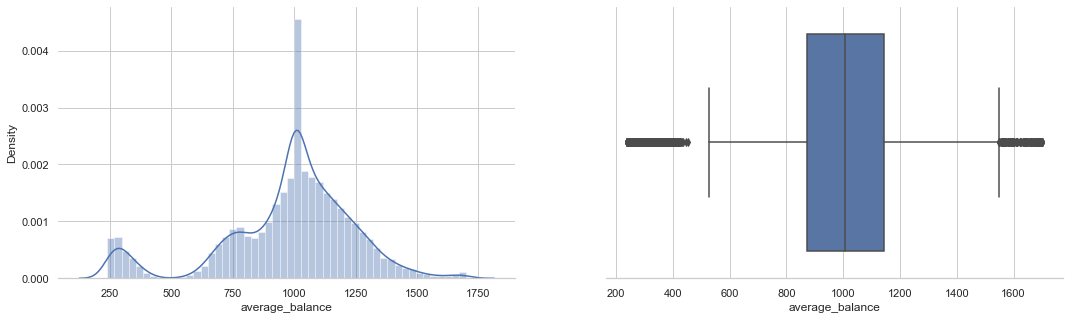

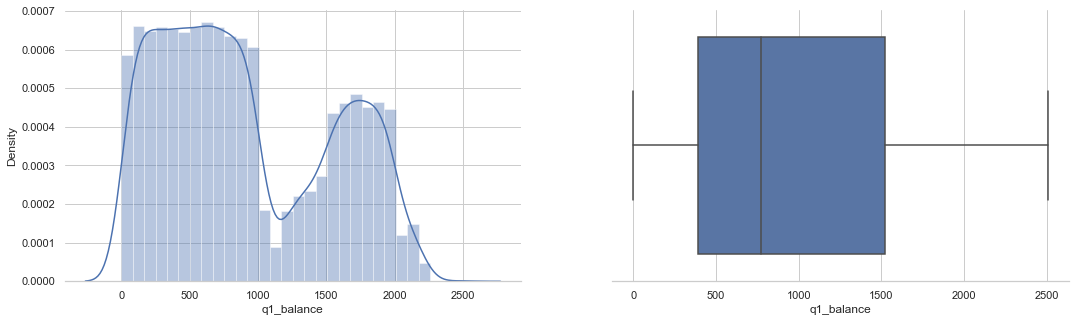

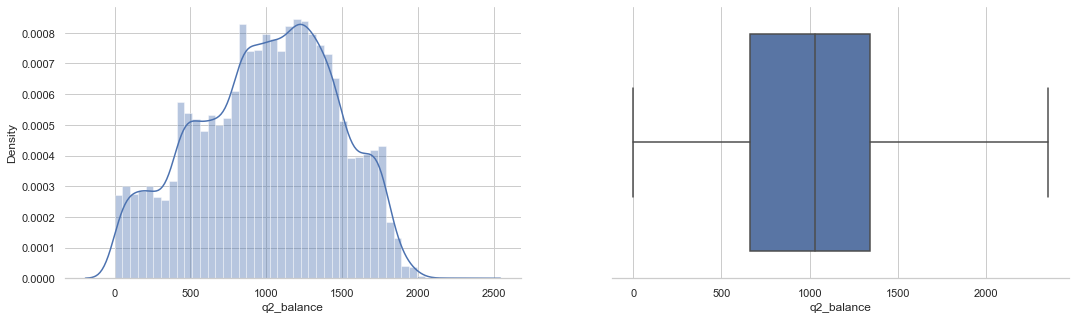

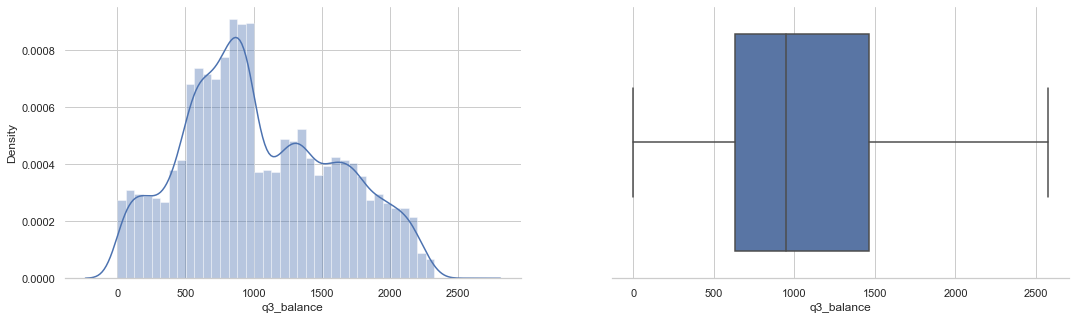

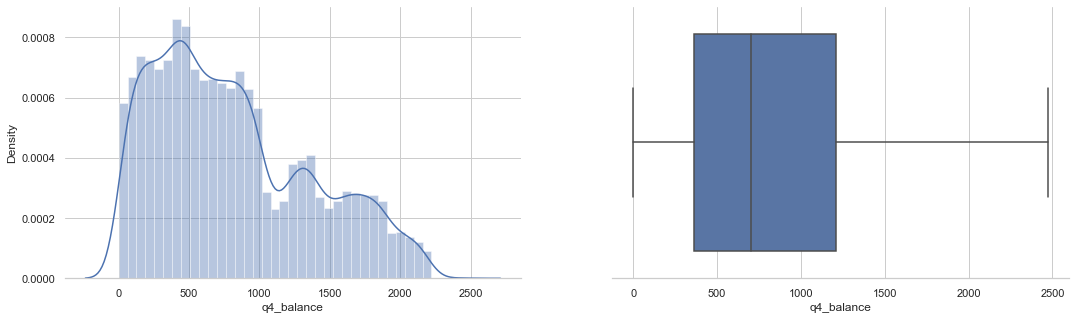

In [37]:
plots_continuous_var(data_outliers_cont)

**Conclusion**

The **quarterly balances slightly improved**, judging from the distribution plot. The high amount of outliers in `average_balance` that were replaced with the median changed the distribution significantly and produced thereby more outliers. To improve this, I’m creating an alternative version with windsorisation for this column. 

**Data set without outliers 2**

In [38]:
data_outliers_part2 = data.copy()
data_outliers_part2 = replace_outliers(df=data_outliers_part2, threshold=1.5, skip=['bank_accounts_open', 'credit_cards_held', 'homes_owned', 'household_size'], limit=['average_balance'])

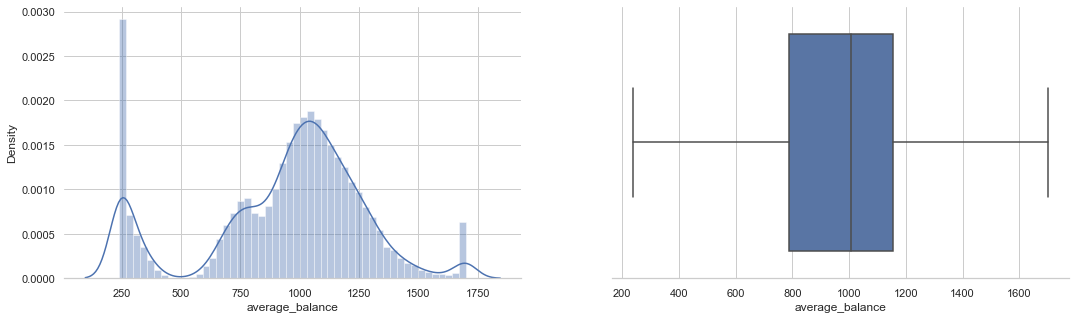

In [39]:
plots_continuous_var(df=data_outliers_part2, columns=['average_balance'])

**Conclusion**

Despite the lack of a visible difference, the change might still have an effect that shown the model metrics later.

**Data set without outliers 3**

Removing outlier in most columns. I'm skipping `homes_owned` and `bank_accounts_open`since they have only 3 values to begin with and the data is pretty heavyly skewed to one class.

In [40]:
data_outliers = data.copy()
data_outliers = replace_outliers(df=data_outliers, threshold=1.5, skip=['bank_accounts_open', 'homes_owned'], limit=['average_balance'])

In [41]:
data_outliers3_bln, data_outliers3_discrete, data_outliers3_cont = var_classification(data_outliers, bln=2, disc=10)


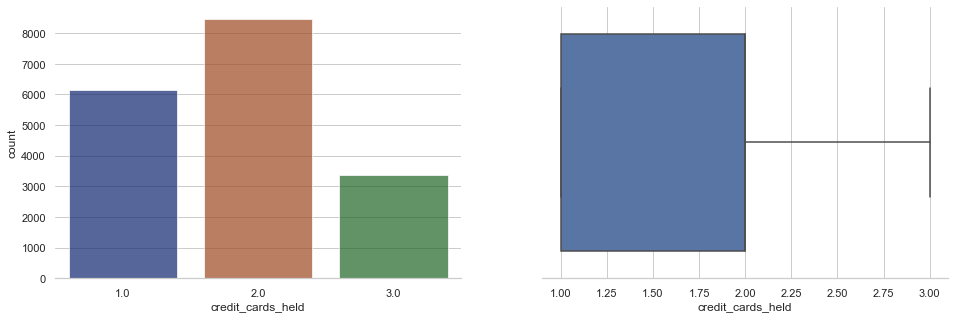

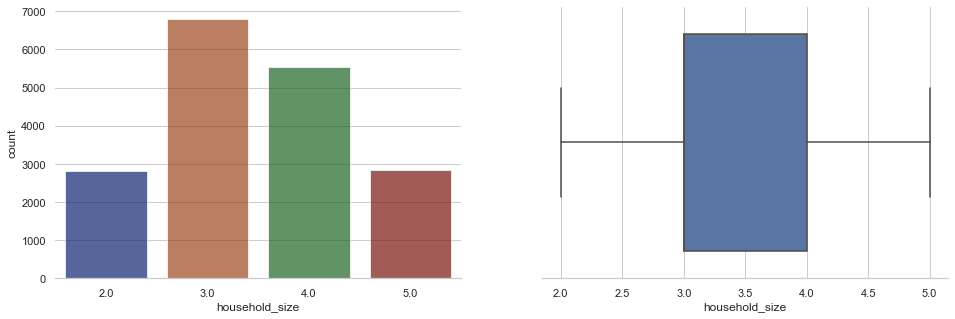

In [42]:
plots_discrete_var(df=data_outliers3_discrete, skip=['reward', 'income_level', 'credit_rating', 'bank_accounts_open', 'homes_owned'])

**Conclusion**

Most outliers were successfully removed.

**Resulting datasets**

- `data_outliers_part1` with outliers replaced with median value in continous variables 
- `data_outliers_part2` with outliers replaced with median value in continous variables but windsorised for `average_balance`
- `data_outliers` with outliers replaced in most numerical variables

**Categorical variables (Encoding)**

Judging from the value exploration in 4 I'm applying the following encoding:

| feature               | encoding type     |
| --------------------- | ----------------- |
| reward                | Get Dummies       |
| mailer_type           | Get Dummies       |
| overdraft_protection  | Get Dummies       |
| own_your_home         | Get Dummies       |
| income_level          | ordinal           |
| credit_rating         | ordinal           |
| offer_accepted        | None (target var) |







In [43]:
# Get dummies encoding

data_dummies = data_cat.drop(['income_level', 'credit_rating', 'offer_accepted'], axis=1)
data_dummies = pd.get_dummies(data_dummies, drop_first=True)


In [44]:
# ordinal encoding

data_ord = data_cat.drop(['offer_accepted', 'reward', 'mailer_type', 'overdraft_protection', 'own_your_home'], axis=1)

data_ord['income_level'] = data_ord['income_level'].map({'Low' : 1, 'Medium' : 2, 'High' : 3})
data_ord['credit_rating'] = data_ord['credit_rating'].map({'Low' : 1, 'Medium' : 2, 'High' : 3})


# 6 Baseline model

I’m creating a **first logistic regression model with a class balanced target variable** to judge it’s performance against subsequent models with further improvements to the dataset. Since dealing with class imbalance is a necessity for a successful model, it is already a part of this baseline model in order to enable a comparison between different sampling techniques and make a choice. Later on, the baseline model is going to be compared to models that incorporate feature engineering techniques like transformations and scaling and use different classification methods such as KNN Classification and Random Forest.

### 6.1. model functions

**Balancing and Classification**

In [45]:
# function to deal with class imbalances in binary classification and performs a logistic regression
# takes inputs: dfs for x, y after x-y-split, model title, method identification string, targeted ratio for maj./min. class
# requires import 'math', 'from imblearn.over_sampling import SMOTE', 'from sklearn.metrics import confusion_matrix', 'from sklearn.metrics import plot_confusion_matrix' 

def balanced_classification(imb_X, test_X, imb_Y, test_Y, title, method='down', ratio=1.5): 
    # values to navigate target variable
    target_col = list(imb_Y.columns.values)[0]
    values_sorted = imb_Y[target_col].value_counts()
    train_imbalanced = pd.concat([imb_X, imb_Y], axis=1)
    
    # the balanced training test has to be equal to the imbalanced in case method == weights
    bal_X = imb_X
    bal_Y = imb_Y
    
    # class weights set to 1 in case method != weights
    weights = {values_sorted.index[0]: 1, 
               values_sorted.index[1]: 1}
    
    # SMOTE
    if method == 'smo':
        smote = SMOTE()
        bal_X, bal_Y = smote.fit_resample(imb_X, imb_Y)
    
    # Class weighting
    elif method == 'wgx':
        total = sum(values_sorted)      
        weights = {values_sorted.index[0]: total/(2*ratio*values_sorted[0]), 
                   values_sorted.index[1]: total/(2*values_sorted[1])}
    
    else:    
        # Downsampling
        if method == 'down':
            sample_size = values_sorted[1]
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(round(sample_size*ratio))
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(sample_size)
    
        # Upsampling    
        elif method == 'up':
            sample_size = values_sorted[0]
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(sample_size)
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(round(sample_size/ratio), replace=True)

        # Mix Up-/Downsampling
        elif method == 'mix':
            sample_size = values_sorted[1]
            imbalance_factor = math.floor(values_sorted[0]/values_sorted[1])
            sample_factor = math.floor(imbalance_factor/3)
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(round(sample_size*sample_factor*ratio))
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(round(sample_size*sample_factor), replace=True)
          
        train_sampled = pd.concat([maj_class, min_class]).sample(frac=1)
        # creating dfs of balanced classes to return
        bal_X = train_sampled.drop([target_col], axis=1)
        bal_Y = pd.DataFrame(train_sampled[target_col])

    # model execution
    classification_balanced = LogisticRegression(random_state=23, max_iter=1000, class_weight=weights)
    classification_balanced.fit(bal_X, bal_Y)
    
    # predictions and report
    predictions_balanced = classification_balanced.predict(test_X)
    report_balanced = pd.DataFrame(metrics.classification_report(test_Y, predictions_balanced, output_dict=True)).transpose()
    report_balanced = round(report_balanced, 3)
    
    # AUC score
    auc_balanced = roc_auc_score(test_Y, classification_balanced.predict_proba(test_X)[:, 1])
    
    # subplot config
    print('\n')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # confusion matrix plot
    cf_matrix = confusion_matrix(test_Y, predictions_balanced)
    group1 = 'True ' + values_sorted.index[0]
    group2 = 'False ' + values_sorted.index[0]
    group3 = 'False ' + values_sorted.index[1]
    group4 = 'True ' + values_sorted.index[1]
    group_names = [group1, group2, group3, group4]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',  ax=axes[0])
    
    #ROC-AUC-curve
    y_probabilities = classification_balanced.predict_proba(test_X)
    skplt.metrics.plot_roc_curve(test_Y, y_probabilities, ax=axes[1], title_fontsize='medium', cmap='tab20c')
    plt.show()
    
    # adding AUC to report
    report_balanced['AUC'] = [auc_balanced, np.NaN, report_balanced['precision'].iloc[2], np.NaN, np.NaN]
    report_balanced['AUC'] = round(report_balanced['AUC'], 3)
    report_balanced['AUC'] = report_balanced['AUC'].fillna('-')
    report_balanced = report_balanced[['precision', 'recall', 'f1-score', 'AUC', 'support']]
    
    # dict to store results
    classification_balanced_dict = {}
    classification_balanced_dict['X_train'] = bal_X
    classification_balanced_dict['y_train'] = bal_Y
    classification_balanced_dict['X_test'] = test_X
    classification_balanced_dict['y_test'] = test_Y
    classification_balanced_dict['title'] = title
    classification_balanced_dict['classification'] = classification_balanced
    classification_balanced_dict['predictions'] = predictions_balanced
    classification_balanced_dict['report'] = report_balanced
    classification_balanced_dict['AUC'] = auc_balanced

    return classification_balanced_dict
    

**Model comparison function**

In [46]:
# function to zip n lists with equal number of elements into one 1-dimensional list

def zip_list(lists): 
    new_list = []
    for i in range(len(lists[0])):
        for l in lists:
            new_list.append(l[i])
    return new_list

# function with input list of classification model dict as created by the balanced_classification function

def classifier_comparison(modellist):
    comparison_df = pd.DataFrame()
    # lists for comparison df
    accuracy_scores = []
    model_count = 0
    skip_list = []
    
    # extract titles and reports from dict
    reports = []
    modelnames = []
    for class_dict in modellist:
        report = class_dict['report']
        title = class_dict['title']
        reports.append(report)
        modelnames.append(title)
        
    # get values from reports into comparison df
    for classifier_report in reports:
        accuracy_scores.append(classifier_report['precision'].iloc[2])
        comparison_df = pd.concat([comparison_df, classifier_report[0:2]])
        skip_list.append('')
        
    modelnames_filled = zip_list([modelnames, skip_list])
    accuracy_scores_filled = zip_list([accuracy_scores, skip_list])
    comparison_df['model_name'] = modelnames_filled
    comparison_df['accuracy'] = accuracy_scores_filled
    comparison_df['class'] = comparison_df.index
    
    # format comparison df
    comparison_df = comparison_df.set_index('model_name')
    comparison_df = comparison_df[['accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    #comparison_df = comparison_df[['accuracy', 'class', 'precision', 'recall', 'f1-score', 'AUC', 'support']]
    
    return comparison_df


### 6.2. data splitting

**x-y-Split**

Preparing 4 sets of X to compare the original data and data with variations of replaced outliers.

In [47]:
num_outliers_part1 = data_outliers_part1.select_dtypes(np.number)
num_outliers_part2 = data_outliers_part2.select_dtypes(np.number)
num_outliers = data_outliers.select_dtypes(np.number)

data_X_outl = pd.concat([num_outliers, data_dummies, data_ord], axis=1)
data_X_outlpart1 = pd.concat([num_outliers_part1, data_dummies, data_ord], axis=1)
data_X_outlpart2 = pd.concat([num_outliers_part2, data_dummies, data_ord], axis=1)
data_X = pd.concat([data_num, data_dummies, data_ord], axis=1)
data_y = pd.DataFrame(data['offer_accepted'])


**Train-Test-Split**

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=96)
X_train_outl, X_test_outl, y_train_outl, y_test_outl = train_test_split(data_X_outl, data_y, test_size=0.2, random_state=96)
X_train_outl1, X_test_outl1, y_train_outl1, y_test_outl1 = train_test_split(data_X_outlpart1, data_y, test_size=0.2, random_state=96)
X_train_outl2, X_test_outl2, y_train_outl2, y_test_outl2 = train_test_split(data_X_outlpart2, data_y, test_size=0.2, random_state=96)

### 6.3 Solving Data imbalance

### 6.3.1 Strategies

In [49]:
data_y['offer_accepted'].value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

I'm Comparing different strategies to pick the best performance for a model to apply further improvements to. 

- Downsamling
- Up-/Downsampling Mix
- SMOTE

TomekLinks is not going to be a part of this comparison since it's only useful for smaller class imbalances.


### 6.3.2 Model alternatives

**Logistic Regression w/ Downsampling**

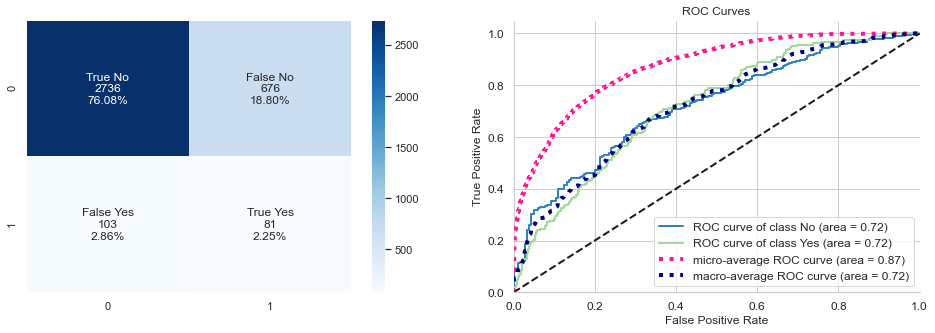

In [50]:
m1_lg_down1 = balanced_classification(X_train, X_test, y_train, y_test, title='LR 1: Linear Regression w/ downsampling', method='down')


In [51]:
m1_lg_down1['report']

,precision,recall,f1-score,AUC,support
No,0.964,0.802,0.875,0.719,3412.000
Yes,0.107,0.440,0.172,-,184.000
accuracy,0.783,0.783,0.783,0.783,0.783
macro avg,0.535,0.621,0.524,-,3596.000
weighted avg,0.920,0.783,0.839,-,3596.000


**Logistic Regression w/ down sampling and class ratio change**

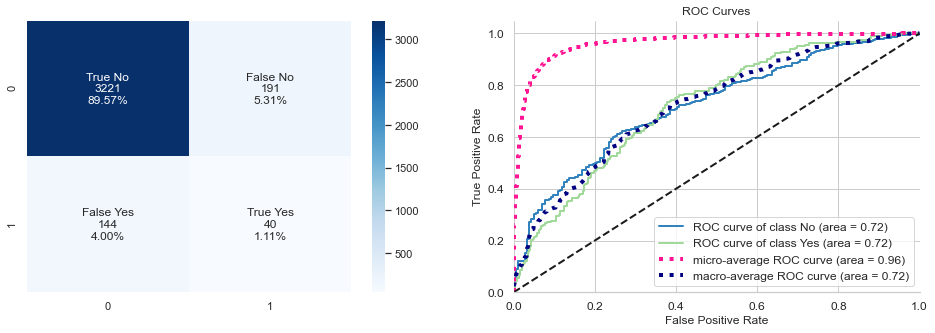

In [52]:
m1_lg_down11 = balanced_classification(X_train, X_test, y_train, y_test, title='LR 1B: Linear Regression w/ downsampling ratio 3', method='down', ratio=3)

In [53]:
m1_lg_down11['report']

,precision,recall,f1-score,AUC,support
No,0.957,0.944,0.951,0.723,3412.000
Yes,0.173,0.217,0.193,-,184.000
accuracy,0.907,0.907,0.907,0.907,0.907
macro avg,0.565,0.581,0.572,-,3596.000
weighted avg,0.917,0.907,0.912,-,3596.000


**Logistic Regression w/ mixed sampling**

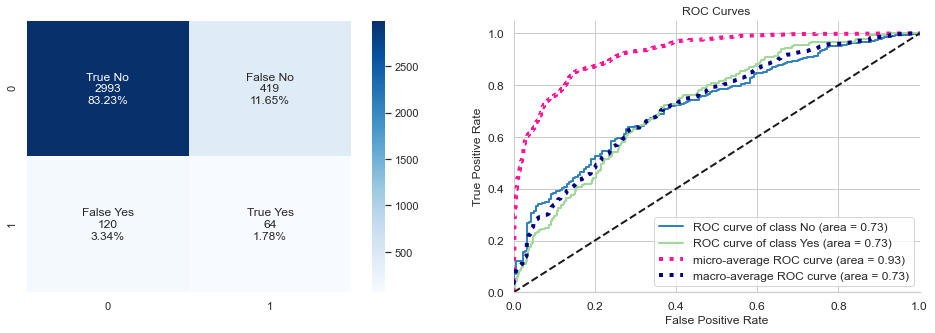

In [54]:
m1_lg_mix1 = balanced_classification(X_train, X_test, y_train, y_test, title='LR 2: Logistic Regression w/ mixed sampling', method='mix', ratio=2)

In [55]:
m1_lg_mix1['report']

,precision,recall,f1-score,AUC,support
No,0.961,0.877,0.917,0.727,3412.00
Yes,0.133,0.348,0.192,-,184.00
accuracy,0.850,0.850,0.850,0.85,0.85
macro avg,0.547,0.613,0.555,-,3596.00
weighted avg,0.919,0.850,0.880,-,3596.00


**Logistic Regression w/ SMOTE**

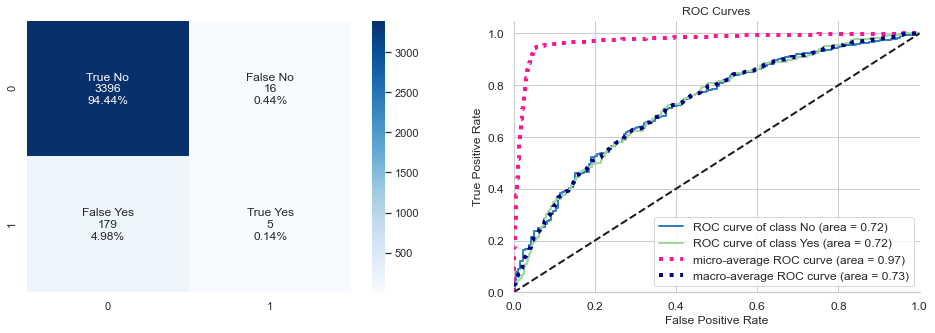

In [56]:
m1_lg_smote1 = balanced_classification(X_train, X_test, y_train, y_test, title= 'LR 3: Logistic Regression w/ SMOTE', method='smo')

In [57]:
m1_lg_smote1['report']

,precision,recall,f1-score,AUC,support
No,0.950,0.995,0.972,0.724,3412.000
Yes,0.238,0.027,0.049,-,184.000
accuracy,0.946,0.946,0.946,0.946,0.946
macro avg,0.594,0.511,0.510,-,3596.000
weighted avg,0.914,0.946,0.925,-,3596.000


### 6.3.3 Comparing Sampling techniques


In [58]:
balanced_models = [m1_lg_down1, m1_lg_down11, m1_lg_mix1, m1_lg_smote1]

balanced_classes_test = classifier_comparison(modellist=balanced_models)
balanced_classes_test

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
LR 1: Linear Regression w/ downsampling,0.783,No,0.964,0.802,0.875,3412.0
,,Yes,0.107,0.440,0.172,184.0
LR 1B: Linear Regression w/ downsampling ratio 3,0.907,No,0.957,0.944,0.951,3412.0
,,Yes,0.173,0.217,0.193,184.0
LR 2: Logistic Regression w/ mixed sampling,0.85,No,0.961,0.877,0.917,3412.0
,,Yes,0.133,0.348,0.192,184.0
LR 3: Logistic Regression w/ SMOTE,0.946,No,0.950,0.995,0.972,3412.0
,,Yes,0.238,0.027,0.049,184.0


**Conclusions** 

Despite the efforts off mitigating the issue in various way, the models behave in a typical way for predicting a target variable with a high class imbalance. In all the cases the accuracy is very high, above 0.95, because by predicting the majority class ‘No’ almost always the accuracy score can be this high. I look at other indicators such as precision and recall reveal the flaws of the model with respect to the minority class ‘Yes’. A downsampling with a class ratio of 2:1 was the most successful in increasing recall for ‘Yes’ to 0.48, compared to values between 0.038 and 0.332. This come with the trade off of decreasing recall for ‘No’. Precision for both classes doesn’t vary much - between 0.95 and 0.97 for ‘No’ and between 0.11 and 0.19 for ‘Yes’. 

**To summarise: The accuracy score has only limited use in this case. Increasing the models ability to find ‘Yes’ makes it worse at finding ‘No’.**

### 6.4 Effects of replacing outliers

Testing different approaches to rereplace outliers and evaluating their impact:


| Model               |  Approach     |
| --------------------- | ----------------- |
| LR 1B                |  outliers removed from continous variables and downsampling     |
| LR 1C                | outliers removed from continous variables with windsorisation for `average_balance` and downsampling        |
| LR 1D                | outliers removed from most numerical features and downsampling       |
| LR 2B                | outliers removed from continous variables with windsorisation for `average_balance` and mixed class sampling       |
| LR 2C                | outliers removed from most numerical features and mixed class sampling           |


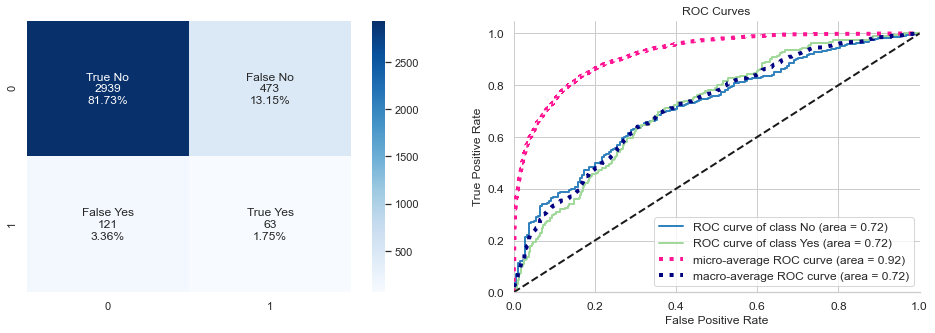

In [59]:
m1_lg_outlp1_down1 = balanced_classification(X_train_outl1, X_test_outl1, y_train_outl1, y_test_outl1, title='LR 1B: LR 1 without outliers 1', method='down', ratio=2)

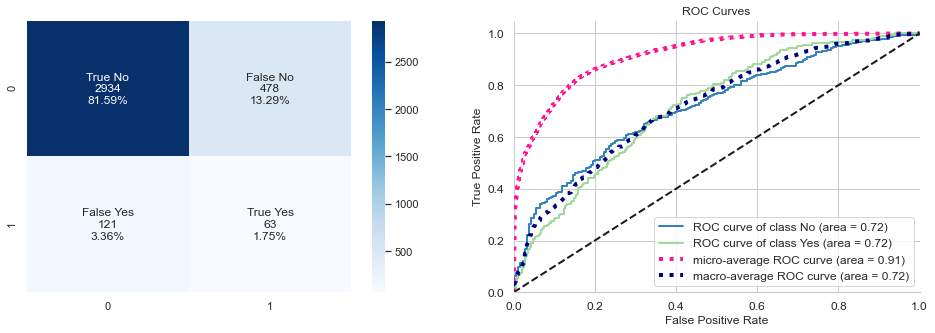

In [60]:
m1_lg_outlp2_down1 = balanced_classification(X_train_outl2, X_test_outl2, y_train_outl2, y_test_outl2, title='LR 1C: LR 1 without outliers 2', method='down', ratio=2)

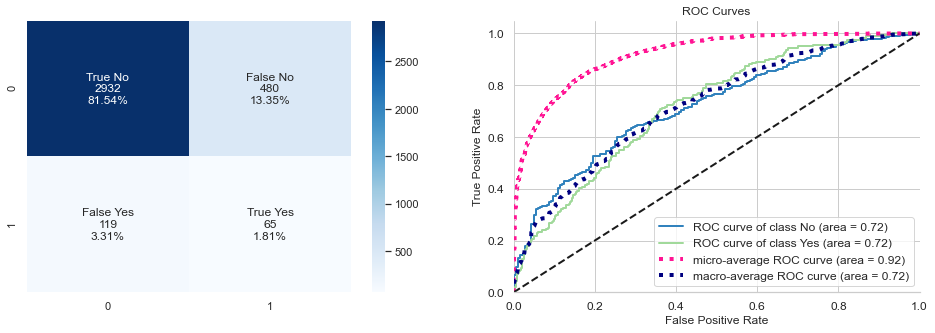

In [61]:
m1_lg_outl_down = balanced_classification(X_train_outl, X_test_outl, y_train_outl, y_test_outl, title='LR 1D: LR 1 without outliers 3', method='down', ratio=2)

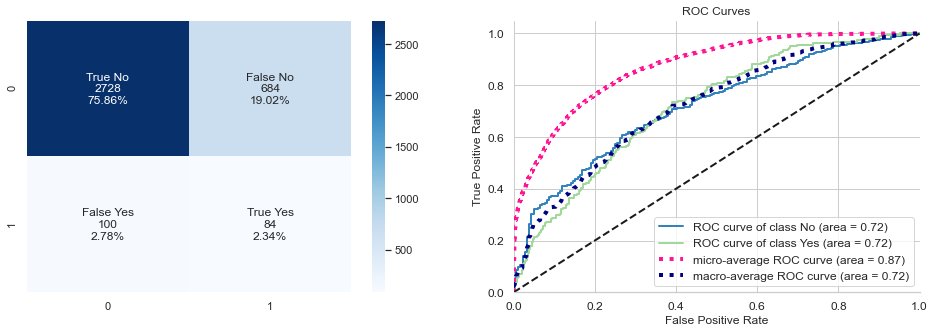

In [62]:
m1_lg_outlp2_mix1 = balanced_classification(X_train_outl2, X_test_outl2, y_train_outl2, y_test_outl2, title= 'LR 2B: LR 2 without outliers 2', method='mix')

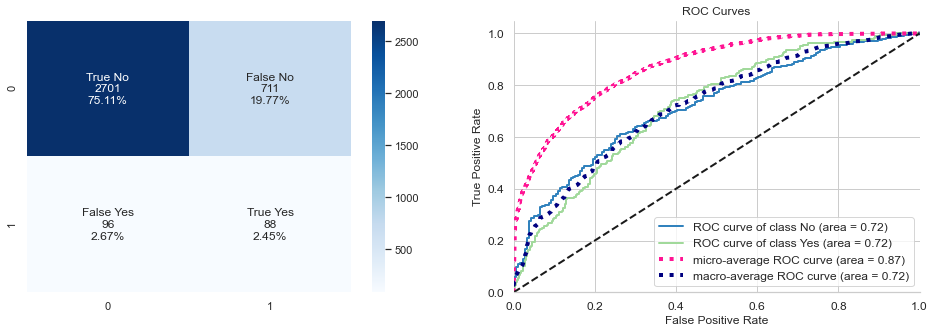

In [63]:
m1_lg_outl_mix1 = balanced_classification(X_train_outl, X_test_outl, y_train_outl, y_test_outl, title= 'LR 2C: LR 2 without outliers 3', method='mix')

In [64]:
outlier_models = [m1_lg_down1, m1_lg_outlp1_down1, m1_lg_outlp2_down1, m1_lg_outl_down, m1_lg_mix1, m1_lg_outlp2_mix1, m1_lg_outl_mix1]

outliers_test = classifier_comparison(modellist=outlier_models)
outliers_test

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
LR 1: Linear Regression w/ downsampling,0.783,No,0.964,0.802,0.875,3412.0
,,Yes,0.107,0.440,0.172,184.0
LR 1B: LR 1 without outliers 1,0.835,No,0.960,0.861,0.908,3412.0
,,Yes,0.118,0.342,0.175,184.0
LR 1C: LR 1 without outliers 2,0.833,No,0.960,0.860,0.907,3412.0
,,Yes,0.116,0.342,0.174,184.0
LR 1D: LR 1 without outliers 3,0.833,No,0.961,0.859,0.907,3412.0
,,Yes,0.119,0.353,0.178,184.0
LR 2: Logistic Regression w/ mixed sampling,0.85,No,0.961,0.877,0.917,3412.0


**Conclusions**

Compared to the models without dealing with outliers, this step **moves the performance indicators in opposite directions depending on which sampling technique it is applied with**. In combination with mixed sampling (Upsampling + Downsampling) the accuracy falls slightly - 0.844 to around 0.78 - and the same trade off as in the previous step between the recall value of the to classes takes place. Although in one case the recall for ‘No’ doesn’t fall by much (0.799) with a corresponding recall for ‘Yes’ of 0.446. 

In combination with downsampling the opposite happens. The accuracy increases sleight from 0.778 up to 0.843 and all variations of removed outliers only change the recall ratio toward ‘No’ by a little (0.86 vs. 0.35).

**Going forward**

**Because of the different strengths and weaknesses of the baseline model variations, I’m continuing to compare the following models to different variations, instead of selecting only one.**

# 7 Model building

### 7.1 Model builing approach

To achieve a diverse range of models to compare, I’m going through the model building process in the following way:

 - Testing KNN Classifier 
 - Testing selected other classification algorithms (i.e. Random Forrest)
 - Summarising results up to this point
 - Model improvements by feature engineering
 - Model improvements by combined approach
 - Comparing results

### 7.2 Model functions

**various classification models**

In [65]:
# fuction to select and exectue a classifer model
# take inputs model dict, k as parameter for KNNClassifer, n for RandomForestClassifier, weight ratio for LogisticRegression

def classification_generator(model, title, cfr, weight_ratio=1, n=0, k=0):
    # values to navigate target variable
    target_col = list(model['y_train'].columns.values)[0]
    values_sorted = model['y_train'][target_col].value_counts()

    # model execution  
    if cfr == 'LR':
        # Class weighting
        if weight_ratio == 1:
            weights = {values_sorted.index[0]: 1, 
                       values_sorted.index[1]: 1}
        else:
            total = sum(values_sorted)      
            weights = {values_sorted.index[0]: total/(2*weight_ratio*values_sorted[0]), 
                       values_sorted.index[1]: total/(2*values_sorted[1])}
        
        classification = LogisticRegression(random_state=23, max_iter=1000, class_weight=weights)
    
    elif cfr == 'KNC':
        if k == 0:
            k = 5
        classification = KNeighborsClassifier(n_neighbors=k)
        
    elif cfr == 'GP':
        classification = GaussianProcessClassifier(1.0 * RBF(1.0))
        
    elif cfr == 'DT':
        classification = DecisionTreeClassifier(max_depth=5)
        
    elif cfr == 'RF':
        if n == 0:
            n = 100
        classification = RandomForestClassifier(max_depth=5, n_estimators=n, max_features=1)
    
    elif cfr == 'MLP':
        classification = MLPClassifier(alpha=1, max_iter=1000)
        
    elif cfr == 'ADA':
        classification = AdaBoostClassifier()
        
    elif cfr == 'NB':
        classification = GaussianNB()
        
    classification.fit(model['X_train'], model['y_train'])
    
    # predictions and report
    predictions = classification.predict(model['X_test'])
    report = pd.DataFrame(metrics.classification_report(model['y_test'], predictions, output_dict=True)).transpose()
    report = round(report, 3)
    
    # AUC score
    roc_auc = roc_auc_score(model['y_test'], classification.predict_proba(model['X_test'])[:, 1])
    
    # subplot config
    print('\n')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # confusion matrix plot
    cf_matrix = confusion_matrix(model['y_test'], predictions)
    group1 = 'True ' + values_sorted.index[0]
    group2 = 'False ' + values_sorted.index[0]
    group3 = 'False ' + values_sorted.index[1]
    group4 = 'True ' + values_sorted.index[1]
    group_names = [group1, group2, group3, group4]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=axes[0])
    
    #ROC-AUC-curve
    y_probabilities = classification.predict_proba(X_test)
    skplt.metrics.plot_roc_curve(y_test, y_probabilities, ax=axes[1], title_fontsize='medium', cmap='tab20c')
    plt.show() 
    
    # adding AUC to report
    report['AUC'] = [roc_auc, np.NaN, report['precision'].iloc[2], np.NaN, np.NaN]
    report['AUC'] = round(report['AUC'], 3)
    report['AUC'] = report['AUC'].fillna('-')
    report = report[['precision', 'recall', 'f1-score', 'AUC', 'support']]
    
    # dict to store results
    classification_dict = {}
    classification_dict['X_train'] = model['X_train']
    classification_dict['y_train'] = model['y_train']
    classification_dict['X_test'] = model['X_test']
    classification_dict['y_test'] = model['y_test']
    classification_dict['title'] = title
    classification_dict['classification'] = classification
    classification_dict['predictions'] = predictions
    classification_dict['report'] = report
    classification_dict['AUC'] = roc_auc
    
    return classification_dict


**KNN Classifer with k parameter tuning**

In [66]:
# function to compare KNN Classifiefer models with different k values basted on the same data set
# itake inputs: model dict, a range interval for the k values to use

def knc_generator(model, k_range):
    comparison_df = pd.DataFrame()
    knc_scores = []
    
    for k in k_range:
        # model execution
        classification = KNeighborsClassifier(n_neighbors=k)
        classification.fit(model['X_train'], model['y_train'])
        
        # predictions and report
        predictions = classification.predict(model['X_test'])
        report = pd.DataFrame(metrics.classification_report(model['y_test'], predictions, output_dict=True)).transpose()
        score = classification.score(model['X_test'], model['y_test'])
        knc_scores.append(score)
        
        # AUC score
        roc_auc = roc_auc_score(model['y_test'], classification.predict_proba(model['X_test'])[:, 1])
        
        # transform knc report for comparison df
        report = round(report[0:2], 3)
        
        # create new columns for comparison df
        model_name = 'KNC with k = ' + str(k)
        name_col = [model_name, '']
        report['model_name'] = name_col
        report['class'] = report.index
        report['accuracy'] = [round(score, 3), '']
        report['AUC'] = [round(roc_auc, 3), 0]
        # concat df from current iteration with previous dfs
        comparison_df = pd.concat([comparison_df, report])
        
    # format comparison df
    comparison_df = comparison_df.set_index('model_name')
    comparison_df = comparison_df[['accuracy', 'class', 'precision', 'recall', 'f1-score', 'AUC', 'support']]
    
    # define variables for plot lines
    X = k_range
    y_maj1 = list(comparison_df['accuracy'].iloc[0:len(comparison_df):2])
    y_maj2 = list(comparison_df['precision'].iloc[0:len(comparison_df):2])
    y_maj3 = list(comparison_df['recall'].iloc[0:len(comparison_df):2])
    y_maj4 = list(comparison_df['f1-score'].iloc[0:len(comparison_df):2])
    y_maj5 = list(comparison_df['AUC'].iloc[0:len(comparison_df):2])
    y_min1 = list(comparison_df['accuracy'].iloc[1:len(comparison_df):2])
    y_min2 = list(comparison_df['precision'].iloc[1:len(comparison_df):2])
    y_min3 = list(comparison_df['recall'].iloc[1:len(comparison_df):2])
    y_min4 = list(comparison_df['f1-score'].iloc[1:len(comparison_df):2])
    y_min5 = list(comparison_df['AUC'].iloc[1:len(comparison_df):2])
    score_list = [[y_maj1, y_maj1], [y_maj2, y_min2], [y_maj3, y_min3], [y_maj4, y_min4], [y_maj5, y_min5]]
    
    # Initialise the subplot function
    print('\n')
    figure, axs = plt.subplots(2, 1, figsize=(8,16))
    
    # display plots
    for pos in range(2):
        axs[pos].plot(X, score_list[0][pos], color = 'green', linestyle='dashed', marker='o', markerfacecolor='green', markersize=8, label='Accuracy')
        axs[pos].plot(X, score_list[1][pos], color = 'blue', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=8, label='Precision')
        axs[pos].plot(X, score_list[2][pos], color = 'black', linestyle='dashed', marker='o', markerfacecolor='black', markersize=8, label='Recall')
        axs[pos].plot(X, score_list[3][pos], color = 'grey', linestyle='dashed', marker='o', markerfacecolor='grey', markersize=8, label='F1-Score')
        axs[pos].plot(X, score_list[4][pos], color = 'brown', linestyle='dashed', marker='o', markerfacecolor='brown', markersize=8, label='AUC')
        axs[pos].set_title('Scores for class ' + comparison_df['class'].iloc[pos])
        axs[pos].legend(loc="upper right", bbox_to_anchor=(1.2, 1))
        axs[pos].set_ylim([0, 1.1])

    plt.show()
            
    return comparison_df

### 7.2 KNN Classifier with k parameter tuning

**Comparing k values for data with mixed sampling**

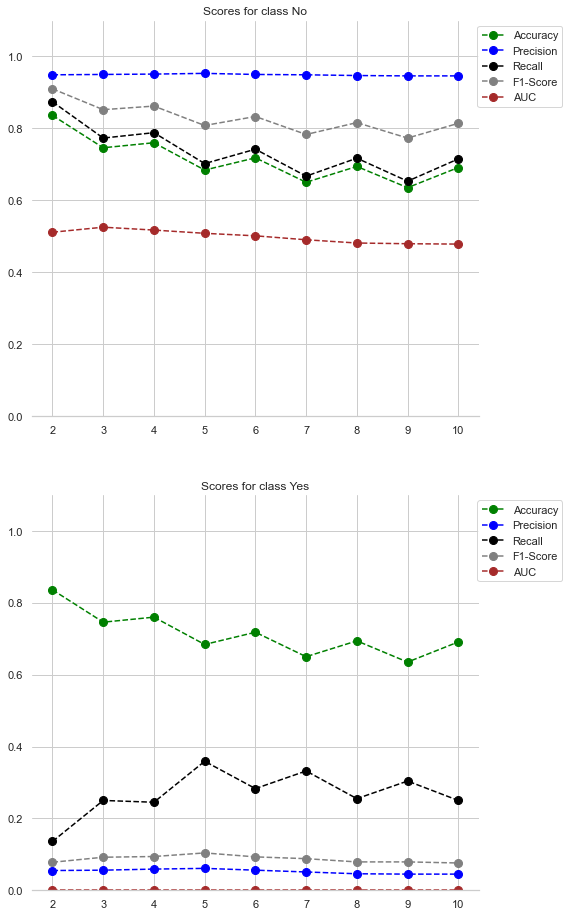

In [67]:
knc_comparison_1 = knc_generator(model=m1_lg_outl_mix1, k_range=range(2,11))

In [68]:
knc_comparison_1

,accuracy,class,precision,recall,f1-score,AUC,support
model_name,,,,,,,
KNC with k = 2,0.836,No,0.949,0.874,0.910,0.511,3412.0
,,Yes,0.055,0.136,0.078,0.000,184.0
KNC with k = 3,0.746,No,0.950,0.773,0.852,0.525,3412.0
,,Yes,0.056,0.250,0.092,0.000,184.0
KNC with k = 4,0.76,No,0.951,0.788,0.862,0.517,3412.0
,,Yes,0.059,0.245,0.094,0.000,184.0
KNC with k = 5,0.684,No,0.953,0.702,0.808,0.508,3412.0
,,Yes,0.061,0.359,0.104,0.000,184.0
KNC with k = 6,0.718,No,0.950,0.742,0.833,0.501,3412.0


**Conclusions**

As observed in previous models the accuracy score is negatively correlated with the ‘Yes’-recall. For the observed interval of k-values, accuracy falls down to 0.533 in the range from k=2 to 7 and rises again until 10. Other indicators - precision, f1-score and AUC, are not early moved by a change in k. Depending on with class one would prioritize, one would pick k=2 for a high ’No’-recall (0.841) or k=7 for a high ‘Yes’-recall.

**Comparing k values for data with downsampling**

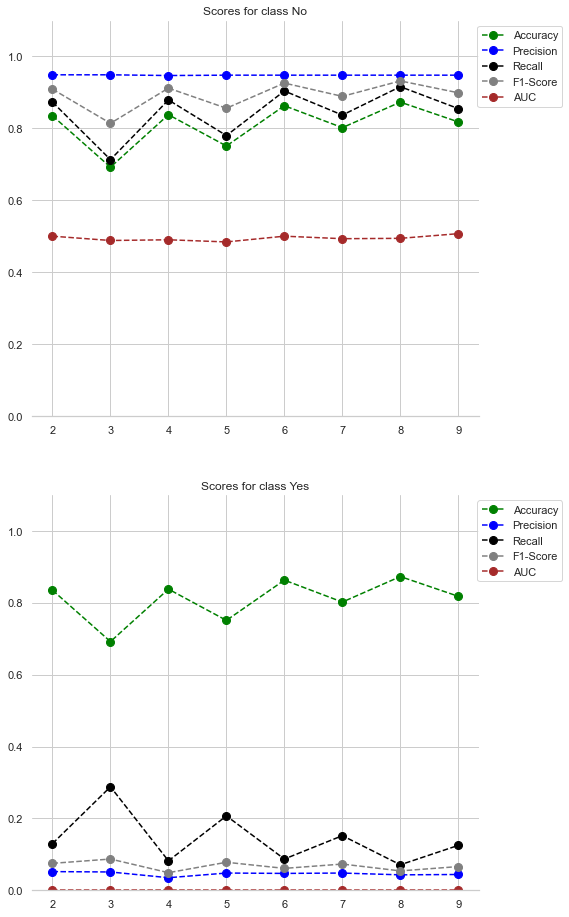

In [69]:
knc_comparison_2 = knc_generator(model=m1_lg_outlp1_down1, k_range=range(2,10))

In [70]:
knc_comparison_2

,accuracy,class,precision,recall,f1-score,AUC,support
model_name,,,,,,,
KNC with k = 2,0.835,No,0.949,0.873,0.909,0.500,3412.0
,,Yes,0.052,0.130,0.075,0.000,184.0
KNC with k = 3,0.692,No,0.949,0.713,0.814,0.488,3412.0
,,Yes,0.051,0.288,0.087,0.000,184.0
KNC with k = 4,0.838,No,0.947,0.879,0.912,0.490,3412.0
,,Yes,0.035,0.082,0.049,0.000,184.0
KNC with k = 5,0.751,No,0.948,0.780,0.856,0.484,3412.0
,,Yes,0.048,0.207,0.078,0.000,184.0
KNC with k = 6,0.863,No,0.948,0.904,0.926,0.500,3412.0


**Conclusions**

KNN Classifer seems to be less sensitive to downsampling compared to the mixed sampling above. Accuracy and ‘Yes’ recall are also negatively correlated here, but they change less overall within the observed range. They oscillate with a light trend upward for the accuracy score and downward for the ‘Yes’ recall with increasing k. 

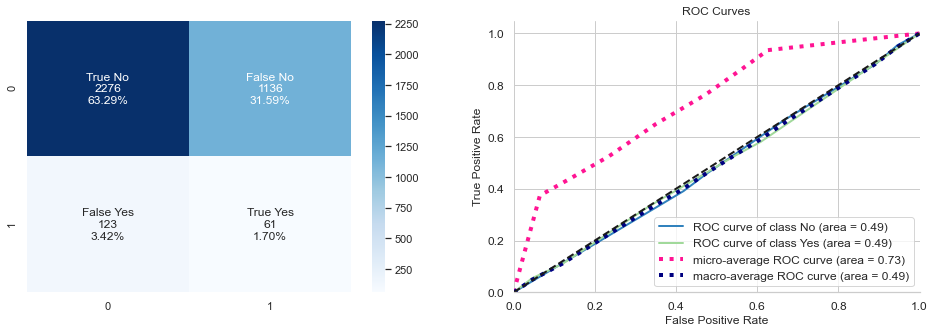

In [71]:
knc_k7 = classification_generator(model=m1_lg_outl_mix1, title='KNN k=7 w/ replaced outliers', cfr='KNC', k=7)

### 7.3 Various classification models

**Random Forest with downsampling**

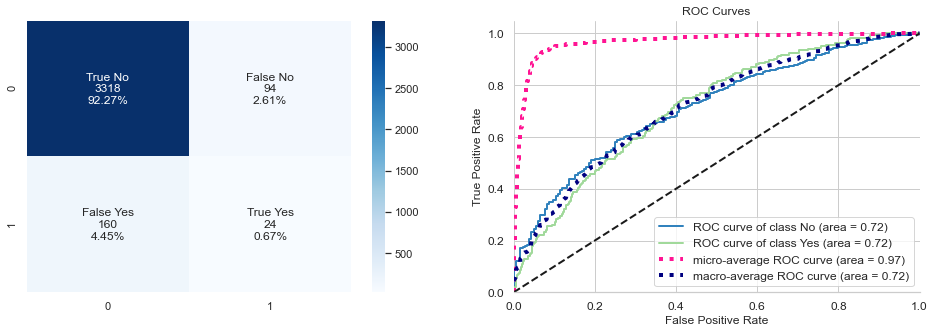

In [72]:
rf1_down = classification_generator(model=m1_lg_down1, title='RF 1: RandomForest w/ downsampling', cfr='RF')

In [73]:
rf1_down['report']

,precision,recall,f1-score,AUC,support
No,0.954,0.972,0.963,0.717,3412.000
Yes,0.203,0.130,0.159,-,184.000
accuracy,0.929,0.929,0.929,0.929,0.929
macro avg,0.579,0.551,0.561,-,3596.000
weighted avg,0.916,0.929,0.922,-,3596.000


**Random Forest with mixed sampling**

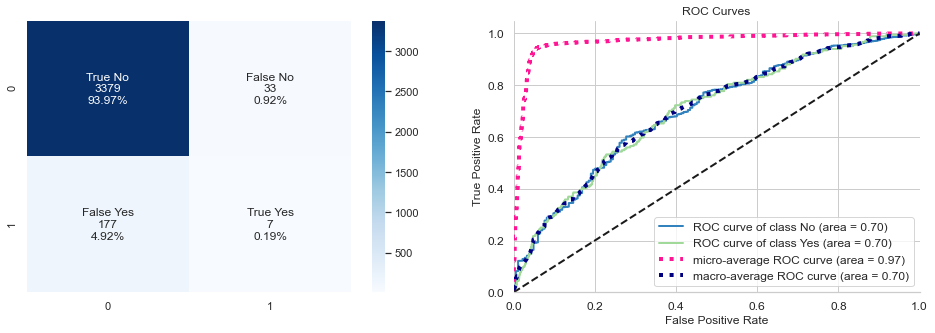

In [74]:
rf2_mix = classification_generator(model=m1_lg_outl_mix1, title='RF 2: RandomForest w/  mixed sampling', cfr='RF', n=20)

In [75]:
rf2_mix['report']

,precision,recall,f1-score,AUC,support
No,0.950,0.990,0.970,0.7,3412.000
Yes,0.175,0.038,0.062,-,184.000
accuracy,0.942,0.942,0.942,0.942,0.942
macro avg,0.563,0.514,0.516,-,3596.000
weighted avg,0.911,0.942,0.923,-,3596.000


**Naive Bayes with downsampling**

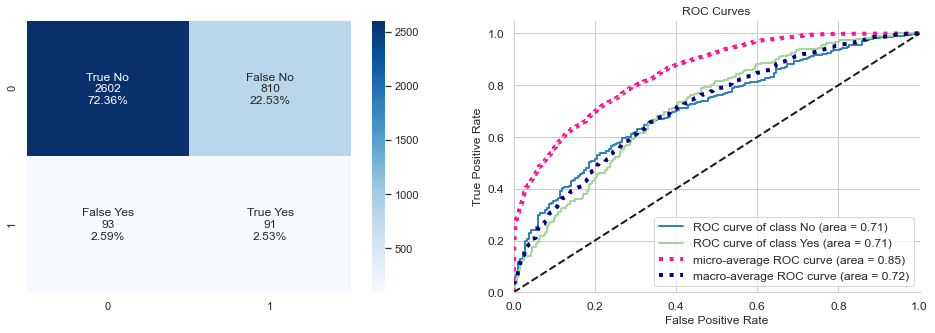

In [76]:
nb1_down = classification_generator(model=m1_lg_down1, title='NB 1: NaiveBayes w/ downsampling', cfr='NB')

In [77]:
nb1_down['report']

,precision,recall,f1-score,AUC,support
No,0.965,0.763,0.852,0.714,3412.000
Yes,0.101,0.495,0.168,-,184.000
accuracy,0.749,0.749,0.749,0.749,0.749
macro avg,0.533,0.629,0.510,-,3596.000
weighted avg,0.921,0.749,0.817,-,3596.000


**Naive Bayes with mixed sampling**

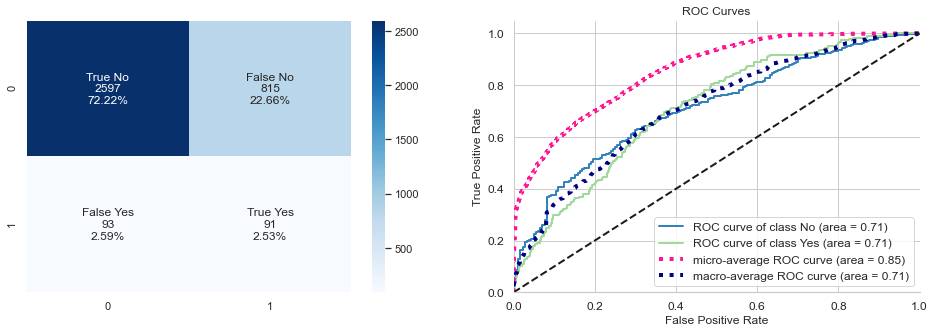

In [78]:
nb2_mix = classification_generator(model=m1_lg_outl_mix1, title='NB 2: NaiveBayes w/ mixed sampling', cfr='NB')

In [79]:
nb2_mix['report']

,precision,recall,f1-score,AUC,support
No,0.965,0.761,0.851,0.712,3412.000
Yes,0.100,0.495,0.167,-,184.000
accuracy,0.747,0.747,0.747,0.747,0.747
macro avg,0.533,0.628,0.509,-,3596.000
weighted avg,0.921,0.747,0.816,-,3596.000


**Conclusions**

deikhe

**KKN Classifier with downsampling**

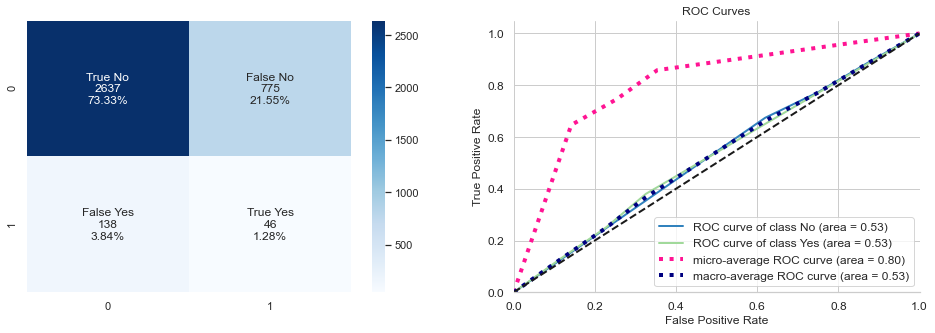

In [80]:
knc3_down = classification_generator(model=m1_lg_outl_mix1, title='KNC 1 : KNN Classifer w/ k=3 + mixed sampling', cfr='KNC', k=3)

### 7.4 preliminary results

In [81]:
cfr_list_various1 = [m1_lg_outl_down, knc3_down, nb2_mix, rf2_mix, rf1_down, nb2_mix]
                   
cfr_comparison_various1 = classifier_comparison(modellist=cfr_list_various1)
cfr_comparison_various1

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
LR 1D: LR 1 without outliers 3,0.833,No,0.961,0.859,0.907,3412.0
,,Yes,0.119,0.353,0.178,184.0
KNC 1 : KNN Classifer w/ k=3 + mixed sampling,0.746,No,0.950,0.773,0.852,3412.0
,,Yes,0.056,0.250,0.092,184.0
NB 2: NaiveBayes w/ mixed sampling,0.747,No,0.965,0.761,0.851,3412.0
,,Yes,0.100,0.495,0.167,184.0
RF 2: RandomForest w/ mixed sampling,0.942,No,0.950,0.990,0.970,3412.0
,,Yes,0.175,0.038,0.062,184.0
RF 1: RandomForest w/ downsampling,0.929,No,0.954,0.972,0.963,3412.0


**Conclusions**

So far the general character of all model was very similar. A very high accuracy score, that decreases with taking care of outliers and different sampling methods, depending on the model downsampling works better than mixed sampling or the other way around. By theses measures with some tweaking, you can increase the ‘Yes’ recall, taking into account a decreasing ‘No’ recall varying slightly in severity depending on the model. A combination of Linear Regression with replaced outliers seems to be relatively effective at this. 

For this reason Linear Regression is staying one of the more frequently used models in the following steps to see how further improvements impact its performance and how it compares again others algorithms with improvements to them.

### 7.5 Model improvements by Feature engineering

### 7.5.1 Boxcox Transformation

**Transformation of training and test set**

In [82]:
X_train.columns.values

array(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance', 'reward_Cash Back', 'reward_Points',
       'mailer_type_Postcard', 'overdraft_protection_Yes',
       'own_your_home_Yes', 'income_level', 'credit_rating'], dtype=object)

In [83]:
X_train_box = X_train
X_test_box = X_test

X_train_box, boxcox1 = boxcox_transform(X_train_box, columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])
X_test_box, boxcox1 = boxcox_transform(X_test_box, columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'], fit=boxcox1)

**Visual evaluation**

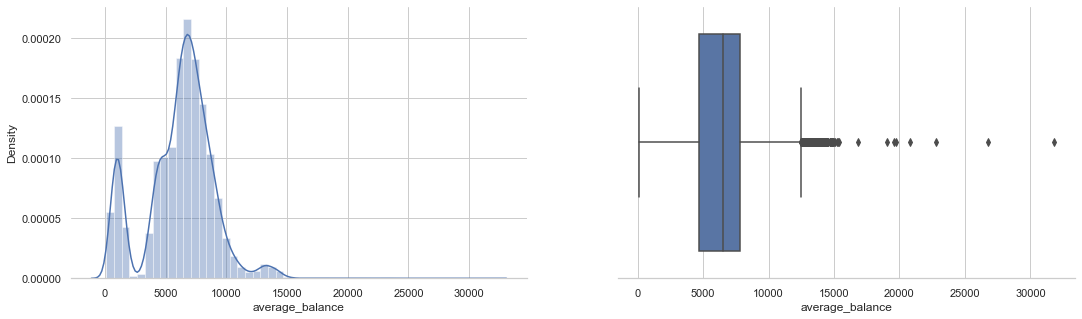

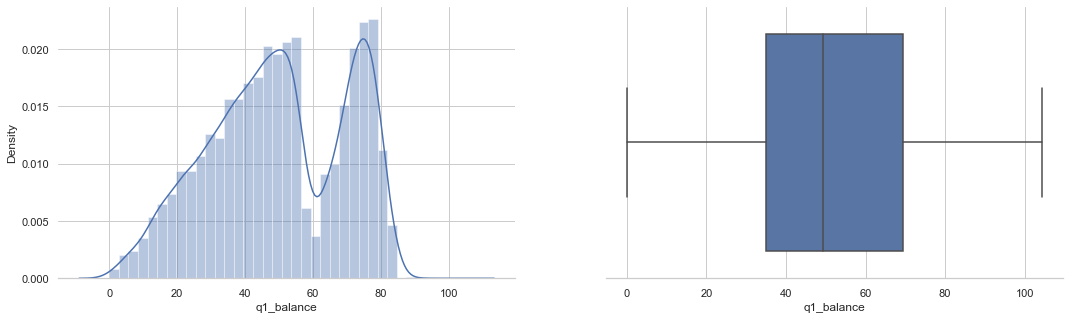

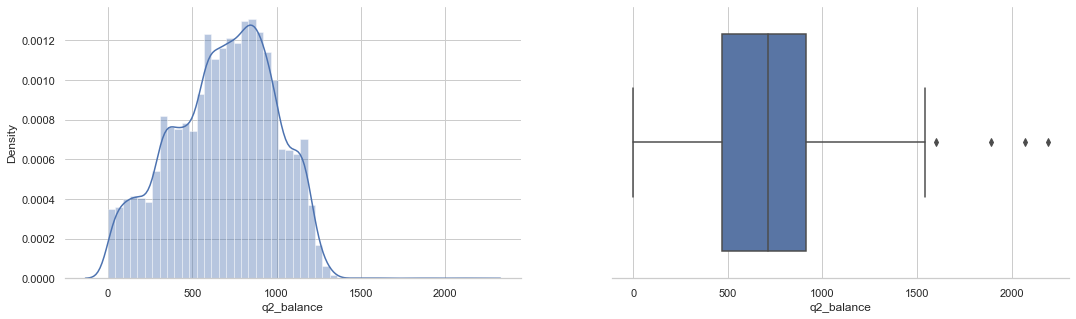

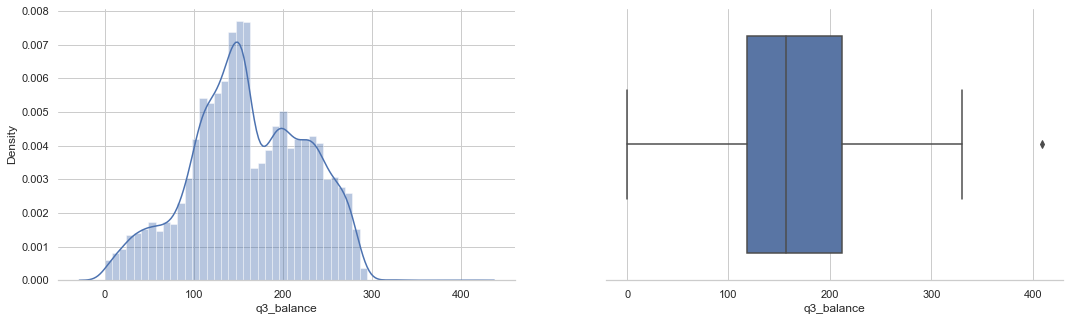

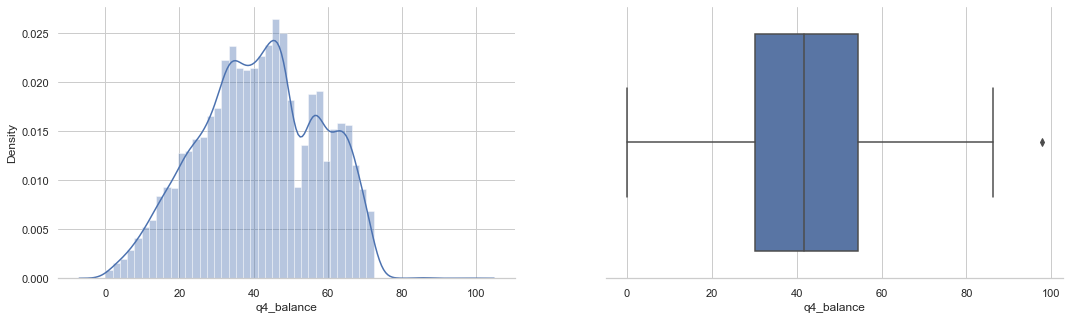

In [84]:
plots_continuous_var(X_train_box, columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])

**Conclusion**

The boxcar transformation bring the variables a little closer to a normal distribution. The peak moves slightly to the middle of the curve, some outliers are taken care of.

**Model execution: Linear Regression with boxcox transformation and downsampling**

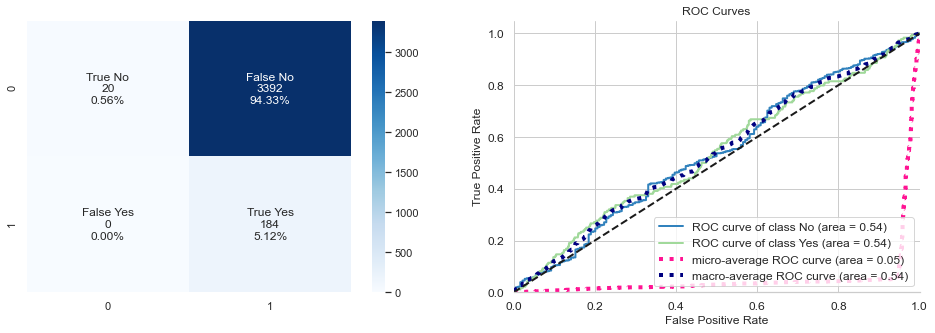

In [85]:
lr_box_down = balanced_classification(X_train_box, X_test_box, y_train, y_test, title= 'LR 4A: LR with boxcox + downsampling', method='down')



In [86]:
lr_box_down['report']

,precision,recall,f1-score,AUC,support
No,1.000,0.006,0.012,0.537,3412.000
Yes,0.051,1.000,0.098,-,184.000
accuracy,0.057,0.057,0.057,0.057,0.057
macro avg,0.526,0.503,0.055,-,3596.000
weighted avg,0.951,0.057,0.016,-,3596.000


**Linear Regression with boxcox and mixed sampling**

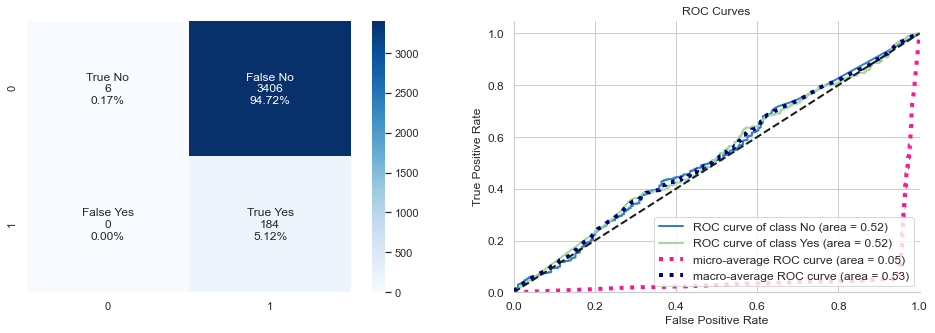

In [87]:
lr_box_mix = balanced_classification(X_train_box, X_test_box, y_train, y_test, title= 'LR 4B: LR with boxcox + mixed sampling', method='mix')


In [88]:
lr_box_mix['report']

,precision,recall,f1-score,AUC,support
No,1.000,0.002,0.004,0.525,3412.000
Yes,0.051,1.000,0.098,-,184.000
accuracy,0.053,0.053,0.053,0.053,0.053
macro avg,0.526,0.501,0.051,-,3596.000
weighted avg,0.951,0.053,0.008,-,3596.000


**Linear Regression with boxcox and SMOTE**

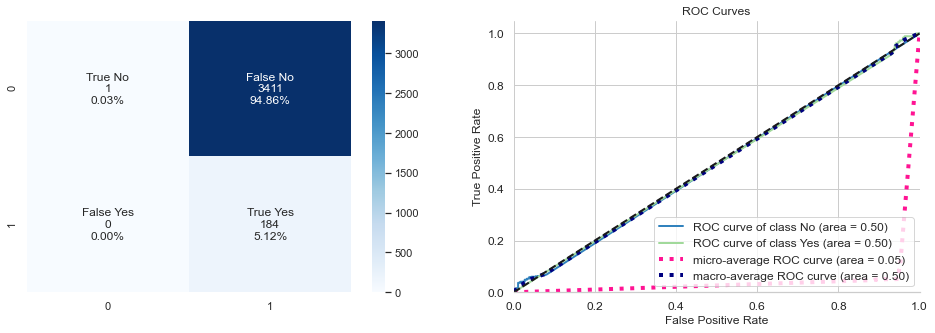

In [89]:
lr_box_smote = balanced_classification(X_train_box, X_test_box, y_train, y_test, title='LR 4C: LR with boxcox + SMOTE', method='smo')


In [90]:
lr_box_smote['report']

,precision,recall,f1-score,AUC,support
No,1.000,0.000,0.001,0.495,3412.000
Yes,0.051,1.000,0.097,-,184.000
accuracy,0.051,0.051,0.051,0.051,0.051
macro avg,0.526,0.500,0.049,-,3596.000
weighted avg,0.951,0.051,0.006,-,3596.000


**KNN Classifier with downsampling and boxcox transformation**

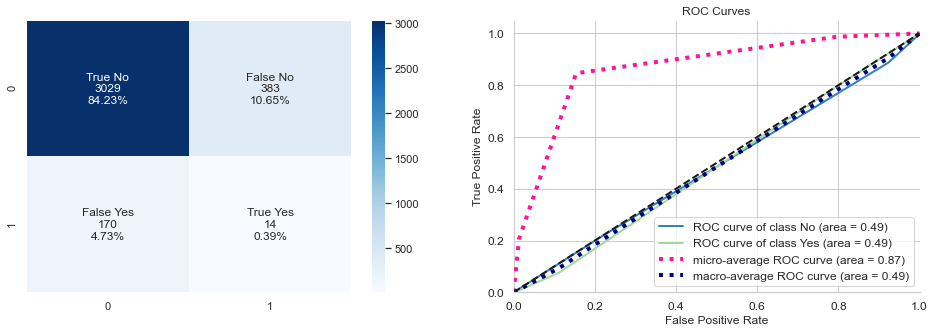

In [91]:
knc_box_down = classification_generator(model=lr_box_down, title='KNN Classifier / k = 3 with boxcox + downsampling', cfr='KNC', k=3)

In [92]:
knc_box_down['report']

,precision,recall,f1-score,AUC,support
No,0.947,0.888,0.916,0.485,3412.000
Yes,0.035,0.076,0.048,-,184.000
accuracy,0.846,0.846,0.846,0.846,0.846
macro avg,0.491,0.482,0.482,-,3596.000
weighted avg,0.900,0.846,0.872,-,3596.000


**Decision Tree with boxcox and downsampling**

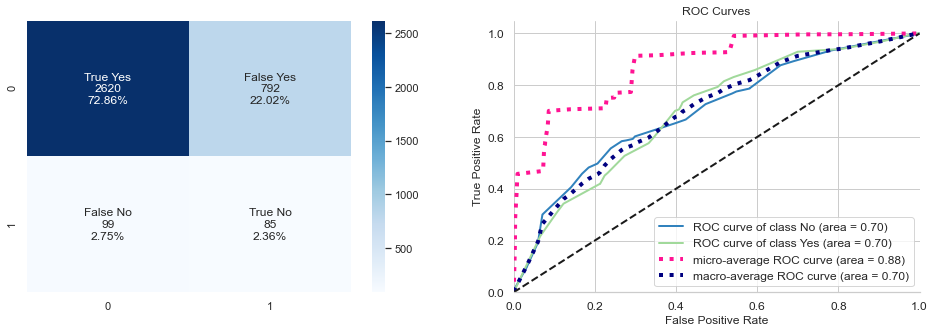

In [93]:
dt_box_smote = classification_generator(model=lr_box_smote, title='Decision Tree with boxcox + SMOTE', cfr='DT')

In [94]:
dt_box_smote['report']

,precision,recall,f1-score,AUC,support
No,0.964,0.768,0.855,0.698,3412.000
Yes,0.097,0.462,0.160,-,184.000
accuracy,0.752,0.752,0.752,0.752,0.752
macro avg,0.530,0.615,0.507,-,3596.000
weighted avg,0.919,0.752,0.819,-,3596.000


**Conclusions**

In [95]:
lg_list_boxcox1 = [lr_box_down, lr_box_mix, lr_box_smote, knc_box_down, dt_box_smote]
                   
cfr_comparison_boxcox1 = classifier_comparison(modellist=lg_list_boxcox1)
cfr_comparison_boxcox1

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
LR 4A: LR with boxcox + downsampling,0.057,No,1.000,0.006,0.012,3412.0
,,Yes,0.051,1.000,0.098,184.0
LR 4B: LR with boxcox + mixed sampling,0.053,No,1.000,0.002,0.004,3412.0
,,Yes,0.051,1.000,0.098,184.0
LR 4C: LR with boxcox + SMOTE,0.051,No,1.000,0.000,0.001,3412.0
,,Yes,0.051,1.000,0.097,184.0
KNN Classifier / k = 3 with boxcox + downsampling,0.846,No,0.947,0.888,0.916,3412.0
,,Yes,0.035,0.076,0.048,184.0
Decision Tree with boxcox + SMOTE,0.752,No,0.964,0.768,0.855,3412.0


**Conclusion**

Some of the results are very different from previous models. (Error?) **Boxcox transformation applied with Linear Regression seems to completely flip the model**. ‘Yes’ recall reaches even 1 while ‘No’ recall goes to almost 0 and the accuracy falls to around 0.5. Notably this happens independent of which sampling method is used. KNN Classifier and Decision Tree perform more in line with previous observation even with boxcox.

### 7.5.2 Normalization

Since normalization can benefit a great deal from a cleaner distribution, I’m using the data sets with replaced outliers for this comparison. Considering there is a tradeoff between the 2 alternatives, normalization of the numerical variables only or the whole data set, it makes sense tocreate 2 sets of x and y data for the modelling to compare the impact. Encoding numerically only will skew the proportionality of the data, normalizing categorical features leads to some loss of information. However out of convenience I'm only using the partially normalize data.


**Creating x and y data for partial normalization**

In [96]:
X_train_norm2_num = X_train_outl2[['bank_accounts_open','credit_cards_held','homes_owned','household_size','average_balance','q1_balance','q2_balance','q3_balance','q4_balance', 'income_level','credit_rating']].copy()
X_test_norm2_num = X_test_outl2[['bank_accounts_open','credit_cards_held','homes_owned','household_size','average_balance','q1_balance','q2_balance','q3_balance','q4_balance', 'income_level','credit_rating']].copy()
X_train_norm2_cat = X_train_outl2[['reward_Cash Back','reward_Points','mailer_type_Postcard','overdraft_protection_Yes', 'own_your_home_Yes']].copy()
X_test_norm2_cat = X_test_outl2[['reward_Cash Back','reward_Points','mailer_type_Postcard','overdraft_protection_Yes', 'own_your_home_Yes']].copy()
y_train_norm2 = y_train_outl2
y_test_norm2 = y_test_outl2

X_train_norm2_num, norm2 = select_normalization(X_train_norm2_num, method=Normalizer())
X_test_norm2_num, norm2 = select_normalization(X_test_norm2_num, method=Normalizer(), fit=norm2)

X_train_norm2_num = X_train_norm2_num.set_index(X_train_norm2_cat.index)
X_test_norm2_num = X_test_norm2_num.set_index(X_test_norm2_cat.index)

X_train_norm2 = pd.concat([X_train_norm2_num, X_train_norm2_cat], axis=1)
X_test_norm2 = pd.concat([X_test_norm2_num, X_test_norm2_cat], axis=1)


**Linear Regression with partial normalization and mixed sampling**

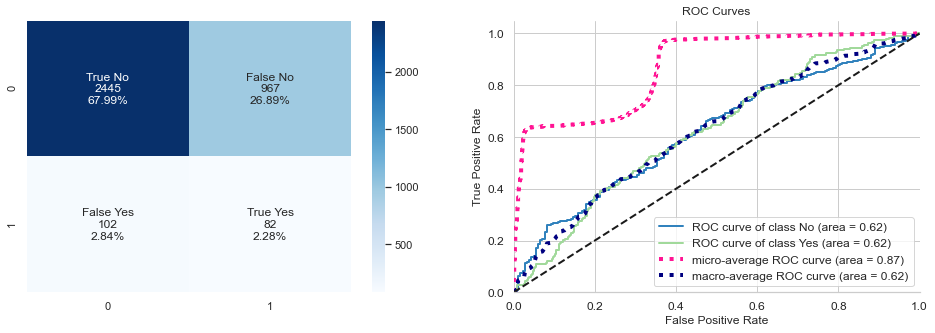

In [97]:
lr_norm_mix = balanced_classification(X_train_norm2, X_test_norm2, y_train_norm2, y_test_norm2, title= 'LR 5A: LR with partial normalization + mixed', method='mix')


In [98]:
lr_norm_mix['report']

,precision,recall,f1-score,AUC,support
No,0.960,0.717,0.821,0.623,3412.000
Yes,0.078,0.446,0.133,-,184.000
accuracy,0.703,0.703,0.703,0.703,0.703
macro avg,0.519,0.581,0.477,-,3596.000
weighted avg,0.915,0.703,0.785,-,3596.000


**Linear Regression with partial normalization and downsampling**

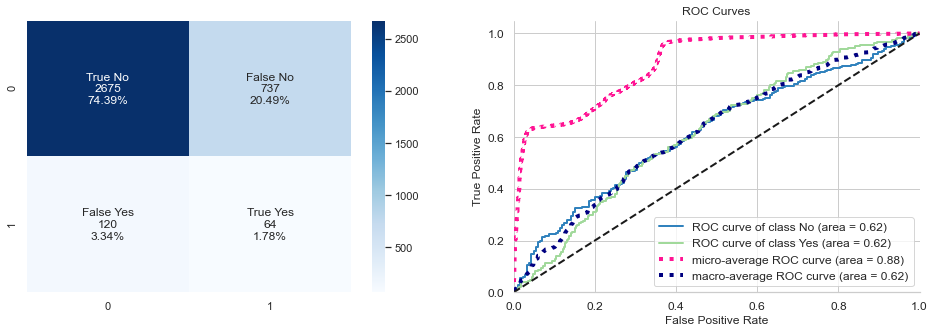

In [99]:
lr_norm_down = balanced_classification(X_train_norm2, X_test_norm2, y_train_norm2, y_test_norm2, title= 'LR 5B: LR with partial normalization + downsampling', method='down')


In [100]:
lr_norm_down['report']

,precision,recall,f1-score,AUC,support
No,0.957,0.784,0.862,0.619,3412.000
Yes,0.080,0.348,0.130,-,184.000
accuracy,0.762,0.762,0.762,0.762,0.762
macro avg,0.518,0.566,0.496,-,3596.000
weighted avg,0.912,0.762,0.824,-,3596.000


**Conclusions**

**KNN Classifier with partial normalization + downsampling**

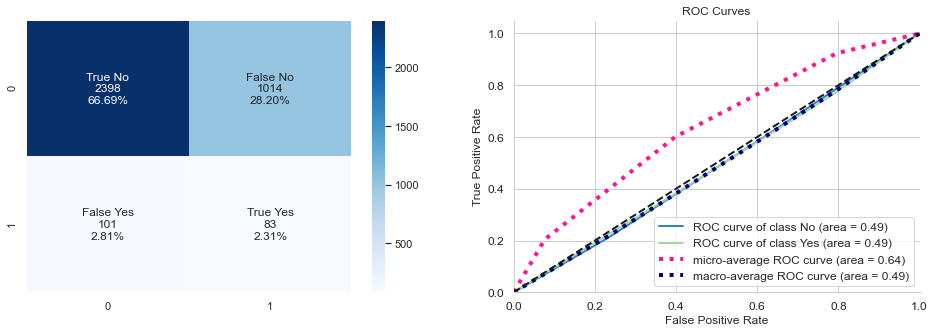

In [101]:
knc_norm_down = classification_generator(model=lr_norm_down, title='KNN Classifier / k = 3 with partial normalization + downsampling', cfr='KNC', k=3)

In [102]:
knc_norm_down['report']

,precision,recall,f1-score,AUC,support
No,0.960,0.703,0.811,0.605,3412.00
Yes,0.076,0.451,0.130,-,184.00
accuracy,0.690,0.690,0.690,0.69,0.69
macro avg,0.518,0.577,0.470,-,3596.00
weighted avg,0.914,0.690,0.776,-,3596.00


**Decision Tree with partial normalization and downsampling**

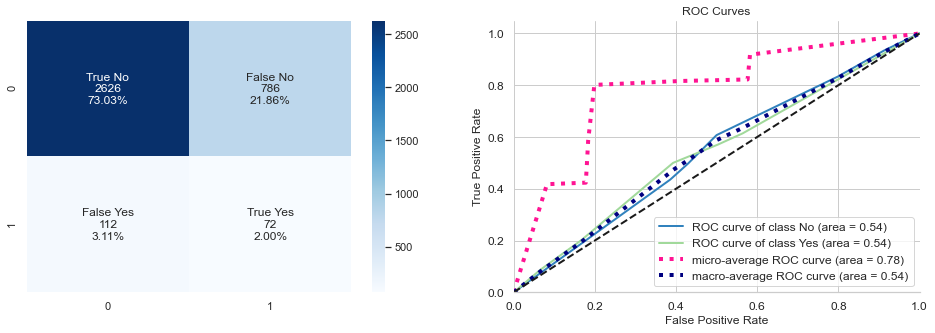

In [104]:
dt_norm_down = classification_generator(model=lr_norm_down, title='Decision Tree with partial normalization + downsampling', cfr='DT')

In [105]:
dt_norm_down['report']

,precision,recall,f1-score,AUC,support
No,0.959,0.770,0.854,0.667,3412.00
Yes,0.084,0.391,0.138,-,184.00
accuracy,0.750,0.750,0.750,0.75,0.75
macro avg,0.522,0.580,0.496,-,3596.00
weighted avg,0.914,0.750,0.817,-,3596.00


In [106]:
model_list_norm1 = [lr_norm_down, lr_norm_mix, knc_norm_down, dt_norm_down]
                   
cfr_comparison_norm1 = classifier_comparison(modellist=model_list_norm1)
cfr_comparison_norm1

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
LR 5B: LR with partial normalization + downsampling,0.762,No,0.957,0.784,0.862,3412.0
,,Yes,0.080,0.348,0.130,184.0
LR 5A: LR with partial normalization + mixed,0.703,No,0.960,0.717,0.821,3412.0
,,Yes,0.078,0.446,0.133,184.0
KNN Classifier / k = 3 with partial normalization + downsampling,0.69,No,0.960,0.703,0.811,3412.0
,,Yes,0.076,0.451,0.130,184.0
Decision Tree with partial normalization + downsampling,0.75,No,0.959,0.770,0.854,3412.0
,,Yes,0.084,0.391,0.138,184.0


**Conclusion**

Normalization is very similar in its effect then the majority of improvement attempts. It triggers a recall trade-off between the 2 classes, decreases the accuracy but doesn’t change much else.

### 7.6 Model improvements by combined approach

**KNN Clasifer with combined improvements**

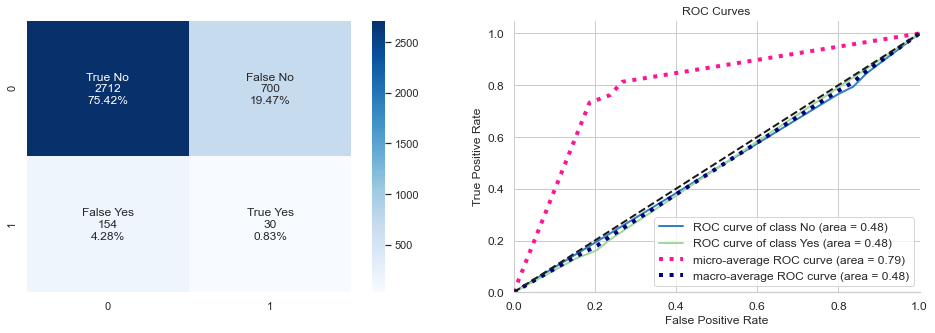

In [107]:
# copying a previous promissing model
knc_3 = m1_lg_outlp2_mix1

# boxcox transformation
knc_3['X_train'], boxcox_k3 = boxcox_transform(knc_3['X_train'], columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])
knc_3['X_test'], boxcox_k3 = boxcox_transform(knc_3['X_test'], columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'], fit=boxcox_k3)

# model execution
knc_3i = classification_generator(model=knc_3, title='KNN Classifier / k = 3 with combined improvements', cfr='KNC', k=3)


In [108]:
knc_3i['report']

,precision,recall,f1-score,AUC,support
No,0.946,0.795,0.864,0.483,3412.000
Yes,0.041,0.163,0.066,-,184.000
accuracy,0.763,0.763,0.763,0.763,0.763
macro avg,0.494,0.479,0.465,-,3596.000
weighted avg,0.900,0.763,0.823,-,3596.000


**Random Forest with combined improvements**

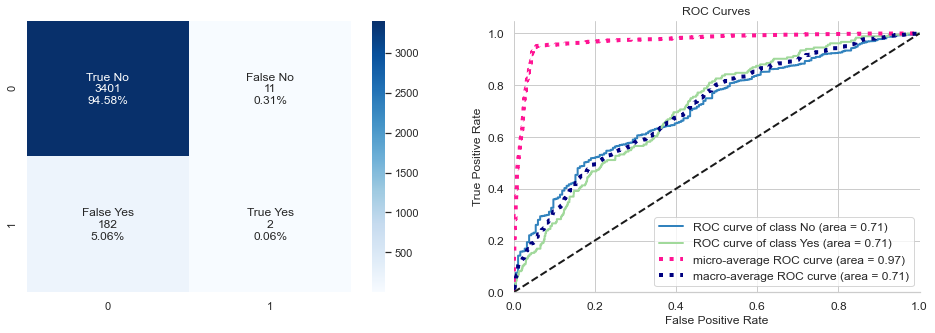

In [109]:
rf_10 = m1_lg_outl_mix1

# boxcox transformation
rf_10['X_train'], boxcox_rf10 = boxcox_transform(rf_10['X_train'], columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])
rf_10['X_test'], boxcox_rf10 = boxcox_transform(rf_10['X_test'], columns=['average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'], fit=boxcox_rf10)

# model execution
rf_10i = classification_generator(model=rf_10, title='Random Forest with combined improvements', cfr='RF', n=100)

**Conclusions**

# 8 Model comparison
**Comparison table of selected models**

In [110]:
model_list_final = [m1_lg_down1, m1_lg_outlp2_mix1, knc_k7, nb2_mix, lr_box_down, dt_norm_down, knc_3i, rf_10i]
                   
cfr_comparison_final = classifier_comparison(modellist=model_list_final)
cfr_comparison_final

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
LR 1: Linear Regression w/ downsampling,0.783,No,0.964,0.802,0.875,3412.0
,,Yes,0.107,0.440,0.172,184.0
LR 2B: LR 2 without outliers 2,0.782,No,0.965,0.800,0.874,3412.0
,,Yes,0.109,0.457,0.176,184.0
KNN k=7 w/ replaced outliers,0.65,No,0.949,0.667,0.783,3412.0
,,Yes,0.051,0.332,0.088,184.0
NB 2: NaiveBayes w/ mixed sampling,0.747,No,0.965,0.761,0.851,3412.0
,,Yes,0.100,0.495,0.167,184.0
LR 4A: LR with boxcox + downsampling,0.057,No,1.000,0.006,0.012,3412.0


**Evaluation**

Taking into account a variety of different methods and combinations of those to improve model performance. There is no clear trend in what is successful. Despite dealing with the class imbalance the model never transcended its ‘No’ bias. The most recently tested combinations of improvement techniques turned out to be among the least effective off all in moving any indicators. A Linear Regression with replaced outliers and maybe a tweaked variation of BoxCox is useful for increasing ‘Yes’ recall, meaning it becomes better at finding and correctly identifying ‘Yes’ - but accompanied by a decrease in ‘No’ recall. No model was particularly good in increasing ‘Yes’ precision. Most often below 0.1 only few could bring even close to 0.2. Other indicator were not much impacted by changes to a model. AUC was for the most models between 0.7 and 0.8 not providing and interesting insights. 

**Recommendation**

**Further model improvements:**

There are still roads that I would have liked to explore eg. parameter tuning of less familiar algorithms or detection threshold tuning. 

**Beyond the algorithm:**

A revision of the available data could be interesting. Geographical data, insights from customer satisfaction survey, a look at internal KPIs regarding marketing/communications strategy and processes could open up new possibilities to understand customer behaviour better.

In [111]:
# Abhi:

'''

norm = Normalizer.fit(X_train[col1])
standard = Standardizer.fit(X_train[col2])

transform_dict = {}
transform_dict['norm'] = norm
transform_dict['standard'] = standard

# with open('norm.pickle','wb') as file:
# 	pickle.dump(norm, file)

with open('tranform.pickle','wb') as file:
	pickle.dump(transform_dict, file)

with open('tranform.pickle','rb') as file:
	transform_dict_loaded = pickle.load(file)

transform_dict_loaded['norm']

'''

"\n\nnorm = Normalizer.fit(X_train[col1])\nstandard = Standardizer.fit(X_train[col2])\n\ntransform_dict = {}\ntransform_dict['norm'] = norm\ntransform_dict['standard'] = standard\n\n# with open('norm.pickle','wb') as file:\n# \tpickle.dump(norm, file)\n\nwith open('tranform.pickle','wb') as file:\n\tpickle.dump(transform_dict, file)\n\nwith open('tranform.pickle','rb') as file:\n\ttransform_dict_loaded = pickle.load(file)\n\ntransform_dict_loaded['norm']\n\n"

In [112]:
'''
# NOT WORKING: df_rest has a lot of NaNs in result > set index right before concat
# function to choose between StandardScaler(), MinMaxScaler(), Normalizer()
# take inputs: dataframe, normaization function, columns to skip, a dict of a previous transformation

def select_normalization(df, method=0, columns=[], skip=[], fit=0):    
    # creating a new df based on the columns that should be transformed
    columns_new = []
    df_rest = pd.DataFrame()
    
    if columns != []:
        columns_new = [ column for column in columns if column not in skip ]
        df_new = df[columns_new].copy()
        df_rest = df.drop(columns_new, axis=1)
    else:
        if skip != []:
            df_new = df.drop(skip, axis=1) 
            df_rest = df[skip].copy()
        else:
            df_new = df.copy()
            
    # creating list to store which columns are transformed
    columns_norm_list = list(df_new.columns.values)
            
    # applying normalization
    if fit != 0:
        # apply previous transformations from fit
        df_new = fit.transform(df_new)
        transformer = fit
    else:
        # apply new transformation 
        transformer = method.fit(df_new)
        df_new = transformer.transform(df_new)
        
    # concat transformed data with rest
    df_new = pd.DataFrame(df_new)
    df = pd.concat([df_new, df_rest], axis=1)
                
    return df, transformer, columns_norm_list


# inverte normalisation

def inverse_normalization(df, fit, columns=[]):
    df_new = df.copy()
    df_rest = pd.DataFrame()
    
    if columns != []:
        df_new = df[columns].copy()
        df_rest = df.drop(columns, axis=1) 
        
    df_new = fit.inverse_transform(df_new)
    df = pd.concat([df_new, df_rest], axis=1)
        
    return df


# TO DO: Pickle implementation everywhere, create and check all inverse transformers. 


# saving in a pickle
with open('transformer.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('transformer.pickle', 'rb') as file:
    loaded_transformer = pickle.load(file)
    
# if you need to un-scale afterwards, speacially if you scaled target variable:
unscaled_X_train = loaded_transformer.inverse_transform(X_train_)

'''

"\n# NOT WORKING: df_rest has a lot of NaNs in result > set index right before concat\n# function to choose between StandardScaler(), MinMaxScaler(), Normalizer()\n# take inputs: dataframe, normaization function, columns to skip, a dict of a previous transformation\n\ndef select_normalization(df, method=0, columns=[], skip=[], fit=0):    \n    # creating a new df based on the columns that should be transformed\n    columns_new = []\n    df_rest = pd.DataFrame()\n    \n    if columns != []:\n        columns_new = [ column for column in columns if column not in skip ]\n        df_new = df[columns_new].copy()\n        df_rest = df.drop(columns_new, axis=1)\n    else:\n        if skip != []:\n            df_new = df.drop(skip, axis=1) \n            df_rest = df[skip].copy()\n        else:\n            df_new = df.copy()\n            \n    # creating list to store which columns are transformed\n    columns_norm_list = list(df_new.columns.values)\n            \n    # applying normalization\n

In [113]:
# AUC ROC measures the probabilities over the decision of the correct class,
## so for the other metrics a wrong prediction 0.2 --> 1.0 = 0.49 --> 1.0,
## while for AUC ROC 0.49 would be considered a smaller mistake

def binclass_roc_auc(clf, X_test, y_test, n_classes=2, figsize=(6, 5)):
    
    y_score = clf.decision_function(X_test)
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score) #[:, i]) --- for mulitclass roc
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    
    
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

    return roc_auc


In [114]:
# Abhi:

'''
model_dict = {}

for i in range(1,10):
	model_dict[i] = {}
	# model, report, transform
	model_dict[i]['model'] = model
	model_dict[i]['report'] = report


model_dict = {
	'1': {
	'model': sfasdsa,
	'report': adsadsa,
	'transform': adsad
	},
	'2': {
	'model': sfasdsa,
	'report': adsadsa,
	'transform': adsad
	}
}
'''

"\nmodel_dict = {}\n\nfor i in range(1,10):\n\tmodel_dict[i] = {}\n\t# model, report, transform\n\tmodel_dict[i]['model'] = model\n\tmodel_dict[i]['report'] = report\n\n\nmodel_dict = {\n\t'1': {\n\t'model': sfasdsa,\n\t'report': adsadsa,\n\t'transform': adsad\n\t},\n\t'2': {\n\t'model': sfasdsa,\n\t'report': adsadsa,\n\t'transform': adsad\n\t}\n}\n"

In [115]:
'''
# NOT WORKING: In model execution u get an error message: ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Creating x and y data for full normalization**

X_train_norm1 = X_train_outl2
X_test_norm1 = X_test_outl2
y_train_norm1 = y_train_outl2
y_test_norm1 = y_test_outl2

X_train_norm1, norm1 = select_normalization(X_train_norm1, method=Normalizer())
X_test_norm1, norm1 = select_normalization(X_train_norm1, method=Normalizer(), fit=norm1)

X_train_norm1 = round(X_train_norm1, 2)
X_test_norm1 = round(X_test_norm1, 2)

'''

"\n# NOT WORKING: In model execution u get an error message: ValueError: Input contains NaN, infinity or a value too large for dtype('float64').\n\n**Creating x and y data for full normalization**\n\nX_train_norm1 = X_train_outl2\nX_test_norm1 = X_test_outl2\ny_train_norm1 = y_train_outl2\ny_test_norm1 = y_test_outl2\n\nX_train_norm1, norm1 = select_normalization(X_train_norm1, method=Normalizer())\nX_test_norm1, norm1 = select_normalization(X_train_norm1, method=Normalizer(), fit=norm1)\n\nX_train_norm1 = round(X_train_norm1, 2)\nX_test_norm1 = round(X_test_norm1, 2)\n\n"